In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')  

# statsmodels.regression.rolling: Importing the RollingOLS class for rolling linear regression.
# pandas_datareader.data: Importing the web module from pandas_datareader for fetching financial data.
# matplotlib.pyplot: Importing the pyplot module for plotting.
# statsmodels.api: Importing the statsmodels library for statistical models and tests.
# pandas: Importing the pandas library for data manipulation and analysis.
# numpy: Importing the numpy library for numerical operations.
# datetime: Importing the datetime module for working with dates.
# yfinance: Importing the yfinance library for fetching financial data from Yahoo Finance.
# pandas_ta: Importing the pandas_ta library for technical analysis.
# warnings: Importing the warnings module to suppress warnings.

# downloading the data
nifty50 = pd.read_html('https://en.wikipedia.org/wiki/NIFTY_50#Constituents')[2]
symbols_list = nifty50['Symbol'].unique().tolist()

# Add '.NS' to each ticker symbol in the list
symbols_list = [ticker + '.NS' for ticker in symbols_list]

# Display the modified list
print(symbols_list)


end_date = '2024-03-02'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

# Setting start and end dates:
# Defining the end_date as '2023-12-03'.
# Calculating the start_date as 8 years (365 days * 8) before the end_date.capitalize

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

['ADANIENT.NS', 'ADANIPORTS.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BPCL.NS', 'BHARTIARTL.NS', 'BRITANNIA.NS', 'CIPLA.NS', 'COALINDIA.NS', 'DIVISLAB.NS', 'DRREDDY.NS', 'EICHERMOT.NS', 'GRASIM.NS', 'HCLTECH.NS', 'HDFCBANK.NS', 'HDFCLIFE.NS', 'HEROMOTOCO.NS', 'HINDALCO.NS', 'HINDUNILVR.NS', 'ICICIBANK.NS', 'INDUSINDBK.NS', 'INFY.NS', 'ITC.NS', 'JSWSTEEL.NS', 'KOTAKBANK.NS', 'LT.NS', 'LTIM.NS', 'M&M.NS', 'MARUTI.NS', 'NESTLEIND.NS', 'NTPC.NS', 'ONGC.NS', 'POWERGRID.NS', 'RELIANCE.NS', 'SBILIFE.NS', 'SBIN.NS', 'SUNPHARMA.NS', 'TATAMOTORS.NS', 'TATASTEEL.NS', 'TCS.NS', 'TATACONSUM.NS', 'TECHM.NS', 'TITAN.NS', 'ULTRACEMCO.NS', 'UPL.NS', 'WIPRO.NS']
[*********************100%%**********************]  50 of 50 completed


adj close        close         high          low  \
date       ticker                                                              
2015-12-07 ADANIENT.NS      41.885914    43.210667    44.000774    43.047195   
           ADANIPORTS.NS   243.889099   255.100006   258.899994   254.500000   
           APOLLOHOSP.NS  1331.183228  1370.599976  1389.650024  1365.849976   
           ASIANPAINT.NS   825.444885   871.450012   873.849976   841.000000   
           AXISBANK.NS     451.848572   462.299988   465.549988   460.299988   
...                               ...          ...          ...          ...   
2023-12-01 TECHM.NS       1220.550049  1220.550049  1226.800049  1211.550049   
           TITAN.NS       3489.500000  3489.500000  3500.000000  3470.000000   
           ULTRACEMCO.NS  9033.849609  9033.849609  9163.400391  8972.000000   
           UPL.NS          575.150024   575.150024   575.950012   569.049988   
           WIPRO.NS        406.782471   407.649994   413.750000   406.500000   

                                 open     volume  
date       ticker                                 
2015-12-07 ADANIENT.NS      43.292400  2366502.0  
           ADANIPORTS.NS   257.850006  2699537.0  
           APOLLOHOSP.NS  1370.300049   135849.0  
           ASIANPAINT.NS   842.000000  1602605.0  
           AXISBANK.NS     462.950012  6335649.0  
...                               ...        ...  
2023-12-01 TECHM.NS       1226.800049  1017856.0  
           TITAN.NS       3499.000000   655263.0  
           ULTRACEMCO.NS  9103.799805   353015.0  
           UPL.NS          570.650024  1811072.0  
           WIPRO.NS        413.750000  4915213.0  

[97614 rows x 6 columns]

### Calculate features and technical indicators

* Garman -klass volatilit
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

In [2]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

# df: This is the DataFrame on which the grouping operation is applied.

# .groupby(level=1): This is a method provided by pandas for grouping data based on one or more levels of a multi-level index. In this case, it's specifying to group the DataFrame by the second level of its index.

# The index of df has two levels ('date' and 'ticker'). By specifying level=1, the grouping is done based on the 'ticker' level. This means that the DataFrame will be split into groups, each corresponding to a unique 'ticker' in the second level of the index.

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

# 1e6 is a shorthand notation in Python for expressing the number 1 followed by 6 zeros, which is equivalent to 1,000,000. It is often used to represent one million in a more concise form.

df

adj close        close         high          low  \
date       ticker                                                              
2015-12-07 ADANIENT.NS      41.885914    43.210667    44.000774    43.047195   
           ADANIPORTS.NS   243.889099   255.100006   258.899994   254.500000   
           APOLLOHOSP.NS  1331.183228  1370.599976  1389.650024  1365.849976   
           ASIANPAINT.NS   825.444885   871.450012   873.849976   841.000000   
           AXISBANK.NS     451.848572   462.299988   465.549988   460.299988   
...                               ...          ...          ...          ...   
2023-12-01 TECHM.NS       1220.550049  1220.550049  1226.800049  1211.550049   
           TITAN.NS       3489.500000  3489.500000  3500.000000  3470.000000   
           ULTRACEMCO.NS  9033.849609  9033.849609  9163.400391  8972.000000   
           UPL.NS          575.150024   575.150024   575.950012   569.049988   
           WIPRO.NS        406.782471   407.649994   413.750000   406.500000   

                                 open     volume  garman_klass_vol        rsi  \
date       ticker                                                               
2015-12-07 ADANIENT.NS      43.292400  2366502.0         -0.000181        NaN   
           ADANIPORTS.NS   257.850006  2699537.0         -0.001050        NaN   
           APOLLOHOSP.NS  1370.300049   135849.0         -0.000175        NaN   
           ASIANPAINT.NS   842.000000  1602605.0          0.000582        NaN   
           AXISBANK.NS     462.950012  6335649.0         -0.000163        NaN   
...                               ...        ...               ...        ...   
2023-12-01 TECHM.NS       1226.800049  1017856.0          0.000068  58.578519   
           TITAN.NS       3499.000000   655263.0          0.000034  67.655236   
           ULTRACEMCO.NS  9103.799805   353015.0          0.000200  65.031393   
           UPL.NS          570.650024  1811072.0          0.000049  50.549769   
           WIPRO.NS        413.750000  4915213.0          0.000045  56.628345   

                            bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                            
2015-12-07 ADANIENT.NS         NaN       NaN       NaN       NaN       NaN   
           ADANIPORTS.NS       NaN       NaN       NaN       NaN       NaN   
           APOLLOHOSP.NS       NaN       NaN       NaN       NaN       NaN   
           ASIANPAINT.NS       NaN       NaN       NaN       NaN       NaN   
           AXISBANK.NS         NaN       NaN       NaN       NaN       NaN   
...                            ...       ...       ...       ...       ...   
2023-12-01 TECHM.NS       7.007478  7.071993  7.136507 -0.065051  0.651957   
           TITAN.NS       8.066861  8.115641  8.164421  0.933685  1.710467   
           ULTRACEMCO.NS  9.041387  9.071900  9.102412  0.574442  1.069452   
           UPL.NS         6.297556  6.327645  6.357735 -1.490376 -0.300013   
           WIPRO.NS       5.923964  5.974753  6.025542 -0.196139  0.311410   

                          dollar_volume  
date       ticker                        
2015-12-07 ADANIENT.NS        99.123099  
           ADANIPORTS.NS     658.387647  
           APOLLOHOSP.NS     180.839910  
           ASIANPAINT.NS    1322.862100  
           AXISBANK.NS      2862.753952  
...                                 ...  
2023-12-01 TECHM.NS         1242.344190  
           TITAN.NS         2286.540239  
           ULTRACEMCO.NS    3189.084420  
           UPL.NS           1041.638105  
           WIPRO.NS         1999.422488  

[97614 rows x 14 columns]

# Taking First 30 Companies beacuse also listed in Sensex

## Getting monthly index and average dollar volume and making it multiindex

In [3]:
last_cols =[c for c in df.columns.unique(0)if c not in['dollar_volume','volume','open','high','low','close']]
# exclude given column and include all the remaining one and store it in last_cols
last_cols
data=pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
# Resamples the 'dollar_volume' column by month, calculates the mean for each month, and then stacks the DataFrame.
#The result is a DataFrame with a MultiIndex containing levels 'date' and 'ticker', with the 'dollar_volume' as a single column.
# The capital M stands for month dollar volume mean is taken             
df.unstack()[last_cols].resample('M').last().stack('ticker')],axis=1).dropna()
# Unstacks the entire DataFrame and selects only the columns specified in last_cols.
# Resamples the resulting DataFrame by month and selects the last value for each month.
data

dollar_volume    adj close  garman_klass_vol  \
date       ticker                                                        
2016-01-31 ADANIENT.NS       300.061194    38.479057          0.000807   
           ADANIPORTS.NS     866.941973   202.922226          0.000095   
           APOLLOHOSP.NS     286.649601  1430.638306          0.001134   
           ASIANPAINT.NS    1137.570630   823.976685         -0.000699   
           AXISBANK.NS      4741.544749   399.167175          0.000825   
...                                 ...          ...               ...   
2023-12-31 TECHM.NS         1242.344190  1220.550049          0.000068   
           TITAN.NS         2286.540239  3489.500000          0.000034   
           ULTRACEMCO.NS    3189.084420  9033.849609          0.000200   
           UPL.NS           1041.638105   575.150024          0.000049   
           WIPRO.NS         1999.422488   406.782471          0.000045   

                                rsi    bb_low    bb_mid   bb_high       atr  \
date       ticker                                                             
2016-01-31 ADANIENT.NS    42.839205  3.578264  3.736252  3.894239 -0.682413   
           ADANIPORTS.NS  32.391080  5.267337  5.403601  5.539864 -0.759085   
           APOLLOHOSP.NS  59.593946  7.161247  7.217102  7.272957 -0.544158   
           ASIANPAINT.NS  50.141908  6.679449  6.714974  6.750498 -1.007255   
           AXISBANK.NS    43.700867  5.899631  5.995922  6.092213 -0.345081   
...                             ...       ...       ...       ...       ...   
2023-12-31 TECHM.NS       58.578519  7.007478  7.071993  7.136507 -0.065051   
           TITAN.NS       67.655236  8.066861  8.115641  8.164421  0.933685   
           ULTRACEMCO.NS  65.031393  9.041387  9.071900  9.102412  0.574442   
           UPL.NS         50.549769  6.297556  6.327645  6.357735 -1.490376   
           WIPRO.NS       56.628345  5.923964  5.974753  6.025542 -0.196139   

                              macd  
date       ticker                   
2016-01-31 ADANIENT.NS   -0.137573  
           ADANIPORTS.NS -0.951787  
           APOLLOHOSP.NS -0.200822  
           ASIANPAINT.NS -0.294384  
           AXISBANK.NS   -0.764268  
...                            ...  
2023-12-31 TECHM.NS       0.651957  
           TITAN.NS       1.710467  
           ULTRACEMCO.NS  1.069452  
           UPL.NS        -0.300013  
           WIPRO.NS       0.311410  

[4748 rows x 9 columns]

In [4]:
data['dollar_volume'].unstack('ticker').rolling(5*12).mean()
#This applies a rolling window operation with a window size of 5*12 (60) periods.

ticker      ADANIENT.NS  ADANIPORTS.NS  APOLLOHOSP.NS  ASIANPAINT.NS  \
date                                                                   
2016-01-31          NaN            NaN            NaN            NaN   
2016-02-29          NaN            NaN            NaN            NaN   
2016-03-31          NaN            NaN            NaN            NaN   
2016-04-30          NaN            NaN            NaN            NaN   
2016-05-31          NaN            NaN            NaN            NaN   
...                 ...            ...            ...            ...   
2023-08-31  5201.338242    4337.348496    2273.918858    3408.969181   
2023-09-30  5289.349008    4414.936800    2294.290898    3430.771451   
2023-10-31  5327.569620    4434.702735    2317.159034    3447.116467   
2023-11-30  5392.606274    4469.741529    2343.440053    3458.263414   
2023-12-31  5450.809708    4487.408669    2382.972450    3476.851482   

ticker      AXISBANK.NS  BAJAJ-AUTO.NS  BAJAJFINSV.NS  BAJFINANCE.NS  \
date                                                                   
2016-01-31          NaN            NaN            NaN            NaN   
2016-02-29          NaN            NaN            NaN            NaN   
2016-03-31          NaN            NaN            NaN            NaN   
2016-04-30          NaN            NaN            NaN            NaN   
2016-05-31          NaN            NaN            NaN            NaN   
...                 ...            ...            ...            ...   
2023-08-31  9123.083433    1631.240376    3854.729185   10268.993441   
2023-09-30  9141.344819    1646.657228    3861.781911   10254.987029   
2023-10-31  9169.345878    1678.113584    3875.297051   10211.609057   
2023-11-30  9182.269954    1706.573618    3892.991986   10295.342659   
2023-12-31  9355.707652    1735.984803    3902.208376   10336.700859   

ticker      BHARTIARTL.NS      BPCL.NS  ...  SUNPHARMA.NS  TATACONSUM.NS  \
date                                    ...                                
2016-01-31            NaN          NaN  ...           NaN            NaN   
2016-02-29            NaN          NaN  ...           NaN            NaN   
2016-03-31            NaN          NaN  ...           NaN            NaN   
2016-04-30            NaN          NaN  ...           NaN            NaN   
2016-05-31            NaN          NaN  ...           NaN            NaN   
...                   ...          ...  ...           ...            ...   
2023-08-31    6377.533761  2145.516239  ...   3519.204878    1410.575366   
2023-09-30    6426.648781  2149.083424  ...   3471.658496    1420.868508   
2023-10-31    6460.267466  2128.857429  ...   3459.743857    1434.236430   
2023-11-30    6489.286531  2149.076667  ...   3429.639138    1451.026717   
2023-12-31    6547.758721  2197.608722  ...   3328.598412    1460.382574   

ticker      TATAMOTORS.NS  TATASTEEL.NS       TCS.NS     TECHM.NS  \
date                                                                
2016-01-31            NaN           NaN          NaN          NaN   
2016-02-29            NaN           NaN          NaN          NaN   
2016-03-31            NaN           NaN          NaN          NaN   
2016-04-30            NaN           NaN          NaN          NaN   
2016-05-31            NaN           NaN          NaN          NaN   
...                   ...           ...          ...          ...   
2023-08-31    9061.829810   7290.974518  7253.127554  2826.779849   
2023-09-30    9096.440346   7304.117433  7287.941981  2845.192860   
2023-10-31    9148.780459   7303.591530  7308.918807  2853.232769   
2023-11-30    9218.938131   7293.391019  7337.597583  2853.486561   
2023-12-31    9301.788477   7310.626136  7333.925477  2850.455167   

ticker         TITAN.NS  ULTRACEMCO.NS       UPL.NS     WIPRO.NS  
date                                                              
2016-01-31          NaN            NaN          NaN          NaN  
2016-02-29          NaN            NaN

In [5]:
data['dollar_vol_rank']= (data.groupby('date')['dollar_volume'].rank(ascending=False))
#selecting rows where the 'dollar_vol_rank' is less than 30.
data = data[data['dollar_vol_rank']<30].drop(['dollar_volume','dollar_vol_rank'],axis=1)

In [6]:
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                              
2016-01-31 ADANIPORTS.NS   202.922226          0.000095  32.391080  5.267337   
           ASIANPAINT.NS   823.976685         -0.000699  50.141908  6.679449   
           AXISBANK.NS     399.167175          0.000825  43.700867  5.899631   
           BHARTIARTL.NS   250.939896          0.000764  31.669949  5.516895   
           BPCL.NS         186.615570         -0.073578  49.383187  5.201137   
...                               ...               ...        ...       ...   
2023-12-31 SBIN.NS         571.750000          0.000063  49.651107  6.319633   
           TATAMOTORS.NS   705.450012          0.000059  66.415028  6.441771   
           TATASTEEL.NS    130.000000          0.000124  64.266803  4.763704   
           TCS.NS         3495.453125          0.000029  55.050007  8.096111   
           ULTRACEMCO.NS  9033.849609          0.000200  65.031393  9.041387   

                            bb_mid   bb_high       atr      macd  
date       ticker                                                 
2016-01-31 ADANIPORTS.NS  5.403601  5.539864 -0.759085 -0.951787  
           ASIANPAINT.NS  6.714974  6.750498 -1.007255 -0.294384  
           AXISBANK.NS    5.995922  6.092213 -0.345081 -0.764268  
           BHARTIARTL.NS  5.598959  5.681023 -0.830294 -0.947035  
           BPCL.NS        5.233735  5.266333 -0.789817 -0.262199  
...                            ...       ...       ...       ...  
2023-12-31 SBIN.NS        6.349924  6.380216 -0.564773 -0.500317  
           TATAMOTORS.NS  6.509480  6.577189  0.780300  1.497726  
           TATASTEEL.NS   4.823854  4.884004 -0.130349  0.657966  
           TCS.NS         8.138220  8.180330 -0.037020  0.266461  
           ULTRACEMCO.NS  9.071900  9.102412  0.574442  1.069452  

[2784 rows x 8 columns]

# Calculate Monthly returns for different time horizion features
* TO capture time series dynamics that reflects ,for example,momentum patterns, we compute historical returns using the method .pct_change(lag) that is, returns over various monthly periods as identified by lags

In [7]:
def calculate_returns(df):
    
   
    outlier_cutoff =0.005
    # what is a outlier
    # refer this video 'https://youtu.be/rZJbj2I-_Ek?feature=shared'
    # an outlier helps us to konw irrelevance in data like 9,10,10,11,12,36 so outlier is used and 36 is removed
    lags=[1,2,3,6,9,12]
    for lag in lags:
        df[f'return_{lag}m']=(df['adj close'] #: Creates a new column in the DataFrame for each lag, representing returns over that lag period.
                            .pct_change(lag)  #Calculates the percentage change over the specified lag period.
                            .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),upper=x.quantile(1-outlier_cutoff)))
                            .add(1)
                            .pow(1/lag)
                            .sub(1))
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna() #Applies the calculate_returns function to each group of the DataFrame, grouping by the second level of the index ('ticker').
# .dropna(): Drops any rows with missing values in the resulting DataFrame.
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                              
2017-01-31 AXISBANK.NS     459.724060         -0.000133  50.399413  6.069462   
           HCLTECH.NS      337.767548         -0.015487  45.978353  5.832812   
           HDFCBANK.NS     612.751892         -0.000721  67.618954  6.324470   
           ICICIBANK.NS    235.550522         -0.000131  55.501093  5.398469   
           INDUSINDBK.NS  1202.090210         -0.000346  65.374094  6.966738   
...                               ...               ...        ...       ...   
2023-12-31 SBIN.NS         571.750000          0.000063  49.651107  6.319633   
           TATAMOTORS.NS   705.450012          0.000059  66.415028  6.441771   
           TATASTEEL.NS    130.000000          0.000124  64.266803  4.763704   
           TCS.NS         3495.453125          0.000029  55.050007  8.096111   
           ULTRACEMCO.NS  9033.849609          0.000200  65.031393  9.041387   

                            bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                             
2017-01-31 AXISBANK.NS    6.126097  6.182732 -0.969123 -0.003962   0.035671   
           HCLTECH.NS     5.859875  5.886938 -0.842721 -0.111814  -0.020291   
           HDFCBANK.NS    6.379680  6.434890 -1.250302  0.417261   0.066697   
           ICICIBANK.NS   5.444866  5.491263 -1.258358 -0.057291   0.053467   
           INDUSINDBK.NS  7.051620  7.136502 -0.784808  1.036651   0.130111   
...                            ...       ...       ...       ...        ...   
2023-12-31 SBIN.NS        6.349924  6.380216 -0.564773 -0.500317   0.012395   
           TATAMOTORS.NS  6.509480  6.577189  0.780300  1.497726  -0.001345   
           TATASTEEL.NS   4.823854  4.884004 -0.130349  0.657966   0.016419   
           TCS.NS         8.138220  8.180330 -0.037020  0.266461   0.006896   
           ULTRACEMCO.NS  9.071900  9.102412  0.574442  1.069452   0.072617   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2017-01-31 AXISBANK.NS    -0.004105  -0.014518  -0.026105  -0.000481   
           HCLTECH.NS      0.004562   0.020541   0.015019   0.011301   
           HDFCBANK.NS     0.035648   0.007254   0.005338   0.015217   
           ICICIBANK.NS    0.006381  -0.009604   0.003799   0.016473   
           INDUSINDBK.NS   0.073411   0.014311   0.010549   0.020340   
...                             ...        ...        ...        ...   
2023-12-31 SBIN.NS         0.005466  -0.015153  -0.000320   0.011952   
           TATAMOTORS.NS   0.059324   0.038315   0.029161   0.059455   
           TATASTEEL.NS    0.046297   0.002837   0.025150   0.028220   
           TCS.NS          0.020989  -0.000743   0.011172   0.011587   
           ULTRACEMCO.NS   0.046121   0.030426   0.037862   0.034033   

                          return_12m  
date       ticker                     
2017-01-31 AXISBANK.NS      0.011840  
           HCLTECH.NS      -0.003492  
           HDFCBANK.NS      0.017787  
           ICICIBANK.NS     0.014789  
           INDUSINDBK.NS    0.025552  
...                              ...  
2023-12-31 SBIN.NS         -0.004287  
           TATAMOTORS.NS    0.051365  
           TATASTEEL.NS     0.014721  
           TCS.NS           0.009042  
           ULTRACEMCO.NS    0.041435  

[2231 rows x 14 columns]

## Download Fama-French Factors and Calculate Rolling Factor Betas.
* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

### what is fama FRench model?

* but Gene Fama and Kenneth French noticed that small-cap stocks (companies with smaller market capitalizations) tended to outperform large-cap stocks and that companies with a higher book-to-market ratio (value stocks) tended to outperform companies with a lower book-to-market ratio (growth stocks).

* MKt-rf= it tells about market risk
* SMB long on portfolio with small cap stocks and short on portfolio on the large cap stocks
* HML long on portfolio with high book to market ratio and short on portfolio with low book to market ratio (low book to market ratio= companies that will grow eg paytm,ideaforage) high book to market are the value stocks
* Robust minus weak (RMW), which compares the returns of firms with high, or robust, operating profitability
* and those with weak, or low, operating profitability; and conservative minus aggressive (CMA)
* we are comparing the number to usa stock market because no data has been available for indian stock market but the numbers are taken on yearly basis so error is less and numbers remain constant

In [8]:
 factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF',axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data= factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2017-01-31 AXISBANK.NS    0.0194 -0.0146 -0.0275 -0.0049 -0.0099   0.035671
           HCLTECH.NS     0.0194 -0.0146 -0.0275 -0.0049 -0.0099  -0.020291
           HDFCBANK.NS    0.0194 -0.0146 -0.0275 -0.0049 -0.0099   0.066697
           ICICIBANK.NS   0.0194 -0.0146 -0.0275 -0.0049 -0.0099   0.053467
           INDUSINDBK.NS  0.0194 -0.0146 -0.0275 -0.0049 -0.0099   0.130111
...                          ...     ...     ...     ...     ...        ...
2023-12-31 SBIN.NS        0.0485  0.0732  0.0493 -0.0306  0.0132   0.012395
           TATAMOTORS.NS  0.0485  0.0732  0.0493 -0.0306  0.0132  -0.001345
           TATASTEEL.NS   0.0485  0.0732  0.0493 -0.0306  0.0132   0.016419
           TCS.NS         0.0485  0.0732  0.0493 -0.0306  0.0132   0.006896
           ULTRACEMCO.NS  0.0485  0.0732  0.0493 -0.0306  0.0132   0.072617

[2231 rows x 6 columns]

In [9]:
observation = factor_data.groupby(level=1).size()
valid_stocks = observation[observation>=10]
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data
# Checks if each 'ticker' is in the index of valid stocks obtained in the previous step.
# factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]: Filters the DataFrame to include only rows corresponding to valid stocks.

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2017-01-31 AXISBANK.NS    0.0194 -0.0146 -0.0275 -0.0049 -0.0099   0.035671
           HCLTECH.NS     0.0194 -0.0146 -0.0275 -0.0049 -0.0099  -0.020291
           HDFCBANK.NS    0.0194 -0.0146 -0.0275 -0.0049 -0.0099   0.066697
           ICICIBANK.NS   0.0194 -0.0146 -0.0275 -0.0049 -0.0099   0.053467
           INDUSINDBK.NS  0.0194 -0.0146 -0.0275 -0.0049 -0.0099   0.130111
...                          ...     ...     ...     ...     ...        ...
2023-12-31 SBIN.NS        0.0485  0.0732  0.0493 -0.0306  0.0132   0.012395
           TATAMOTORS.NS  0.0485  0.0732  0.0493 -0.0306  0.0132  -0.001345
           TATASTEEL.NS   0.0485  0.0732  0.0493 -0.0306  0.0132   0.016419
           TCS.NS         0.0485  0.0732  0.0493 -0.0306  0.0132   0.006896
           ULTRACEMCO.NS  0.0485  0.0732  0.0493 -0.0306  0.0132   0.072617

[2204 rows x 6 columns]

In [10]:
betas =(factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))
betas
#the code calculates rolling betas for each stock by applying the RollingOLS model to the 'return_1m' as the dependent variable and the other factors from the factor_data DataFrame as independent variables. The rolling window size is 
# determined by the minimum of 24 and the number of observations available for each stock. The resulting betas DataFrame contains the time-varying beta coefficients for each stock with respect to the specified factors.
# rolling returns gives the average of any stocks that give return for eg market is up 3% than it wont affect rolling return

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                         
2017-01-31 AXISBANK.NS         NaN       NaN       NaN       NaN       NaN
           HCLTECH.NS          NaN       NaN       NaN       NaN       NaN
           HDFCBANK.NS         NaN       NaN       NaN       NaN       NaN
           ICICIBANK.NS        NaN       NaN       NaN       NaN       NaN
           INDUSINDBK.NS       NaN       NaN       NaN       NaN       NaN
...                            ...       ...       ...       ...       ...
2023-12-31 SBIN.NS        0.284031 -0.578184  0.547449  0.104326 -0.104812
           TATAMOTORS.NS  0.929129 -0.631353  0.826939 -0.067158 -0.969005
           TATASTEEL.NS   0.908873  0.173432 -0.369213 -0.308376  0.475262
           TCS.NS         0.480474  0.014207  0.034159  0.140095  0.041981
           ULTRACEMCO.NS  0.769808  0.804415  0.340988  1.194271 -0.488678

[2204 rows x 5 columns]

In [11]:
factors=['Mkt-RF','SMB','HML','RMW','CMA']

data =data.join(betas.groupby('ticker').shift())
data.loc[:,factors] = data.groupby('ticker',group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.dropna()
data = data.drop('adj close', axis=1)
data
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2165 entries, (Timestamp('2017-01-31 00:00:00'), 'AXISBANK.NS') to (Timestamp('2023-12-31 00:00:00'), 'ULTRACEMCO.NS')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  2165 non-null   float64
 1   rsi               2165 non-null   float64
 2   bb_low            2165 non-null   float64
 3   bb_mid            2165 non-null   float64
 4   bb_high           2165 non-null   float64
 5   atr               2165 non-null   float64
 6   macd              2165 non-null   float64
 7   return_1m         2165 non-null   float64
 8   return_2m         2165 non-null   float64
 9   return_3m         2165 non-null   float64
 10  return_6m         2165 non-null   float64
 11  return_9m         2165 non-null   float64
 12  return_12m        2165 non-null   float64
 13  Mkt-RF            2165 non-null   float64
 14  SMB               2165 non-null   float64

# At this point we have to decide on what ML model and approach to use for predictions etc.
6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* K-Means Clustering

* You may want to initialize predefined centroids for each cluster based on your research.

* Then we will pre-define our centroids for each cluster.

In [12]:
from sklearn.cluster import KMeans

#data = data.drop('cluster',axis=1) # added later after clustering with random

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init='random').fit(df).labels_ # changed 'random' to initial centriods
    return df
data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)
data



garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                           
2017-01-31 AXISBANK.NS           -0.000133  50.399413  6.069462  6.126097   
           HCLTECH.NS            -0.015487  45.978353  5.832812  5.859875   
           HDFCBANK.NS           -0.000721  67.618954  6.324470  6.379680   
           ICICIBANK.NS          -0.000131  55.501093  5.398469  5.444866   
           INDUSINDBK.NS         -0.000346  65.374094  6.966738  7.051620   
...                                    ...        ...       ...       ...   
2023-12-31 SBIN.NS                0.000063  49.651107  6.319633  6.349924   
           TATAMOTORS.NS          0.000059  66.415028  6.441771  6.509480   
           TATASTEEL.NS           0.000124  64.266803  4.763704  4.823854   
           TCS.NS                 0.000029  55.050007  8.096111  8.138220   
           ULTRACEMCO.NS          0.000200  65.031393  9.041387  9.071900   

                           bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                              
2017-01-31 AXISBANK.NS    6.182732 -0.969123 -0.003962   0.035671  -0.004105   
           HCLTECH.NS     5.886938 -0.842721 -0.111814  -0.020291   0.004562   
           HDFCBANK.NS    6.434890 -1.250302  0.417261   0.066697   0.035648   
           ICICIBANK.NS   5.491263 -1.258358 -0.057291   0.053467   0.006381   
           INDUSINDBK.NS  7.136502 -0.784808  1.036651   0.130111   0.073411   
...                            ...       ...       ...        ...        ...   
2023-12-31 SBIN.NS        6.380216 -0.564773 -0.500317   0.012395   0.005466   
           TATAMOTORS.NS  6.577189  0.780300  1.497726  -0.001345   0.059324   
           TATASTEEL.NS   4.884004 -0.130349  0.657966   0.016419   0.046297   
           TCS.NS         8.180330 -0.037020  0.266461   0.006896   0.020989   
           ULTRACEMCO.NS  9.102412  0.574442  1.069452   0.072617   0.046121   

                          return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                       
2017-01-31 AXISBANK.NS    -0.014518  -0.026105  -0.000481    0.011840   
           HCLTECH.NS      0.020541   0.015019   0.011301   -0.003492   
           HDFCBANK.NS     0.007254   0.005338   0.015217    0.017787   
           ICICIBANK.NS   -0.009604   0.003799   0.016473    0.014789   
           INDUSINDBK.NS   0.014311   0.010549   0.020340    0.025552   
...                             ...        ...        ...         ...   
2023-12-31 SBIN.NS        -0.015153  -0.000320   0.011952   -0.004287   
           TATAMOTORS.NS   0.038315   0.029161   0.059455    0.051365   
           TATASTEEL.NS    0.002837   0.025150   0.028220    0.014721   
           TCS.NS         -0.000743   0.011172   0.011587    0.009042   
           ULTRACEMCO.NS   0.030426   0.037862   0.034033    0.041435   

                            Mkt-RF       SMB       HML       RMW       CMA  \
date       ticker                                                            
2017-01-31 AXISBANK.NS    0.858693  0.195109  0.388702 -0.425679  0.043703   
           HCLTECH.NS     0.950129 -0.609863  0.185233 -0.261602  0.071314   
           HDFCBANK.NS    0.459674  0.359985  0.130553 -0.035833  0.222566   
           ICICIBANK.NS   0.729474 -0.673049  0.795082 -0.308013 -0.443778   
           INDUSINDBK.NS  1.021786  0.274579  0.372826 -1.013550 -0.028237   
...                            ...       ...       ...       ...       ...   
2023-12-31 SBIN.NS        0.263798 -0.674279  0.584002  0.017712 -0.183759   
           TATAMOTORS.NS  0.951465 -0.399586  0.824621 -0.055839 -0.909591   
           TATASTEEL.NS   0.924705  0.417283 -0.346779 -0.353718  0.499817   
           TCS.NS         0.500000  0.121058  0.003154  0.214219  0.115056   
           ULTRACEMCO.NS  0.896897  0.448609  0.411564  0.716966 -0.587123   

                  

In [13]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]
# the impoertant thing we are chosing which column iloc[:,5] is atr and 1 is rsi
    plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')
# labeling
    x_label = data.columns[5]
    y_label = data.columns[1]
    plt.title(f'Clusters based on {x_label} and {y_label}')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()
    return

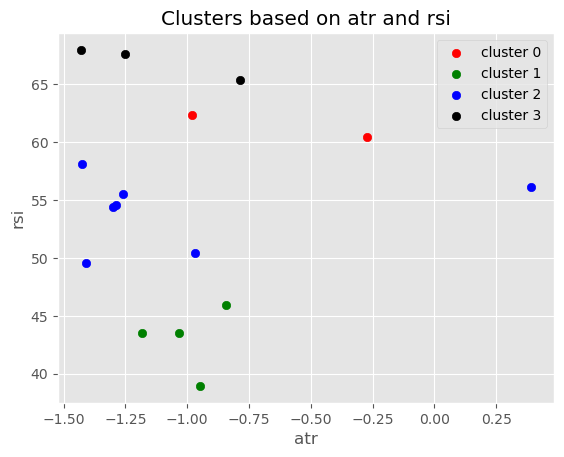

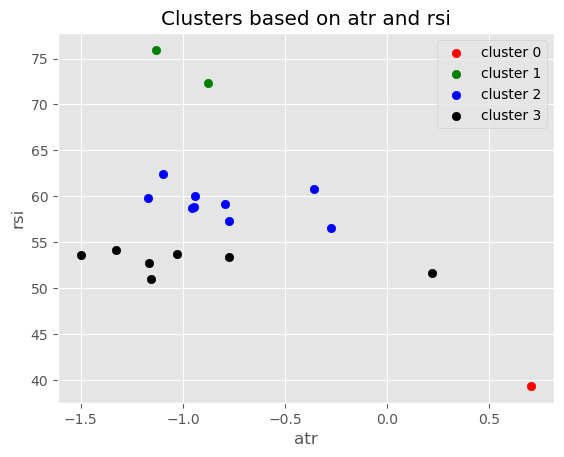

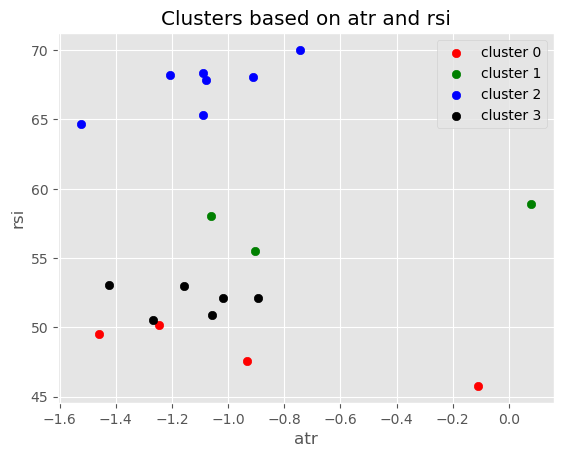

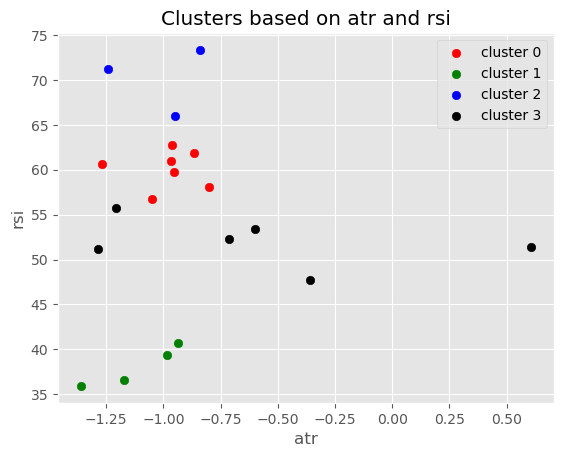

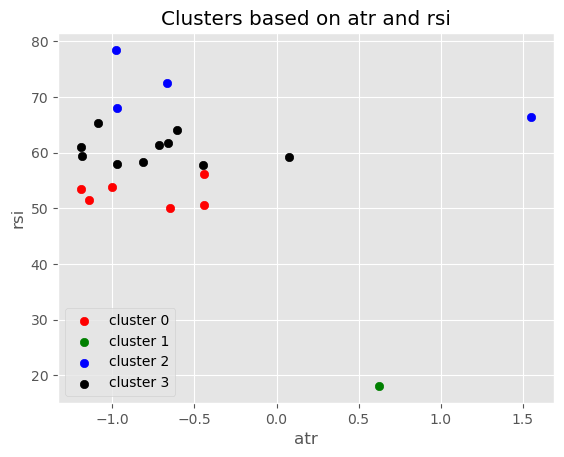

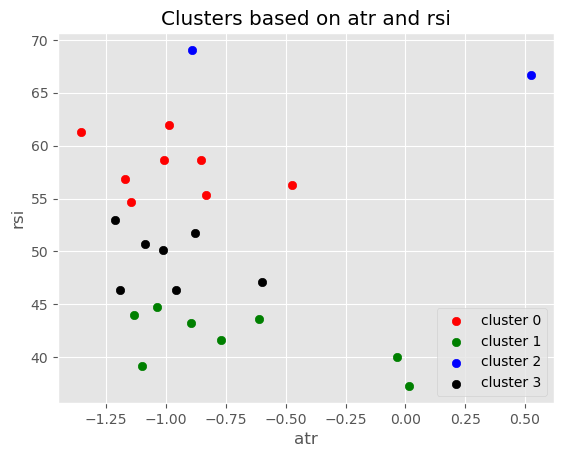

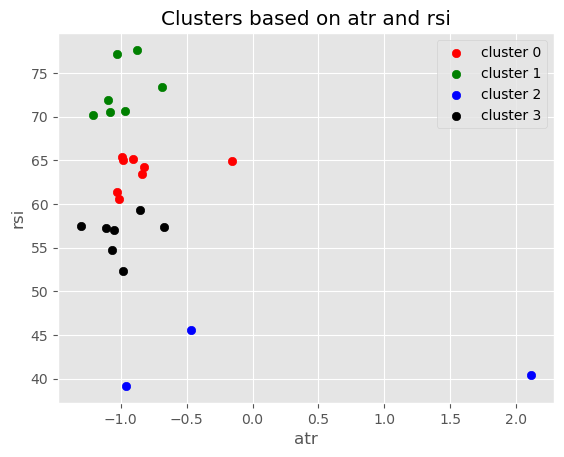

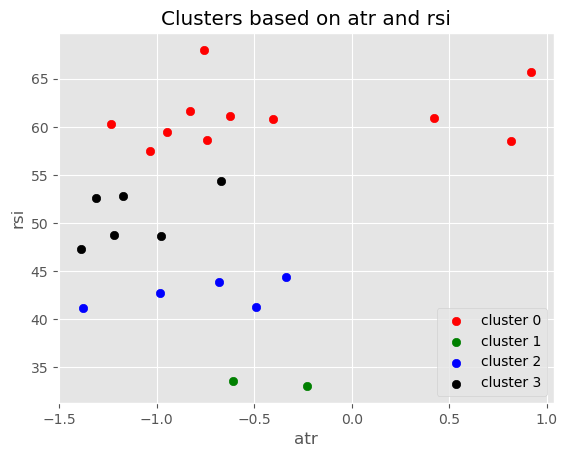

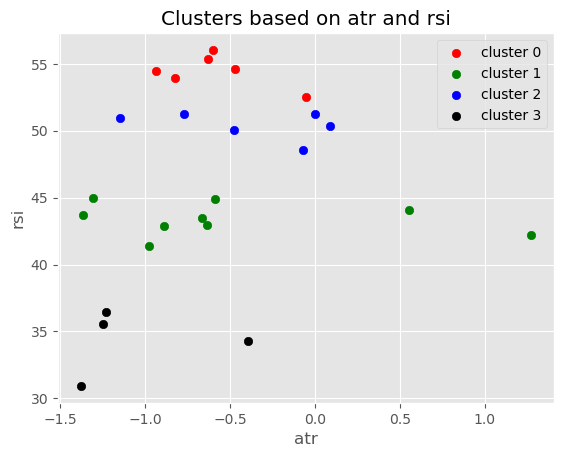

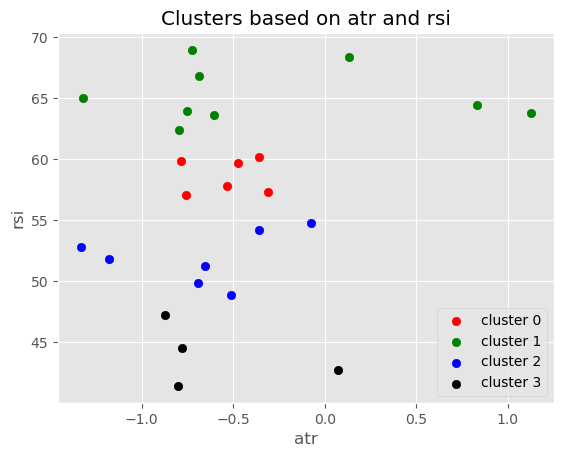

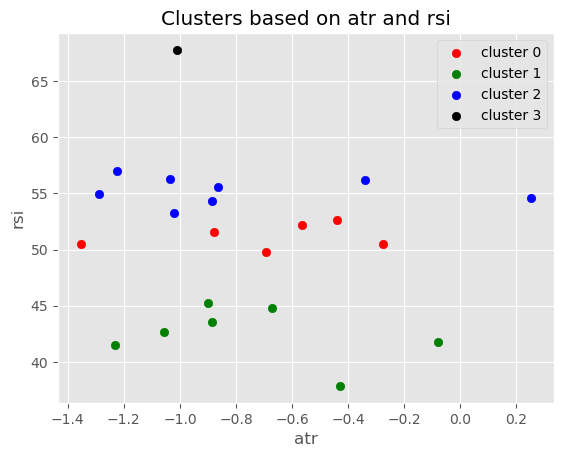

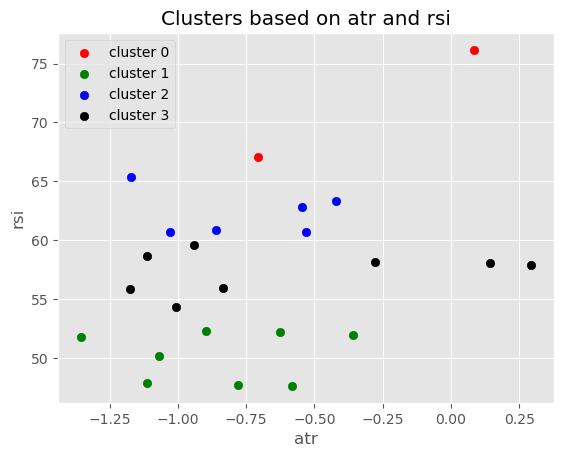

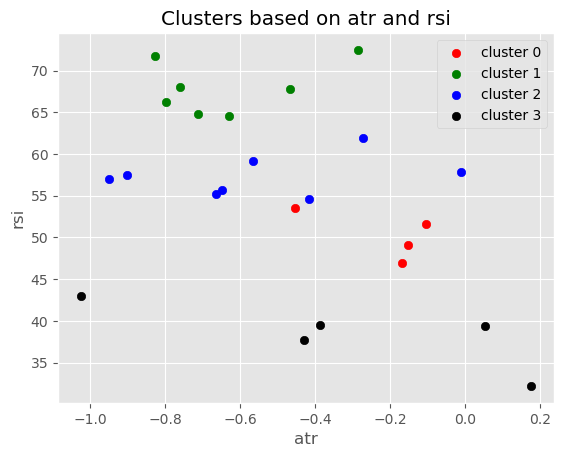

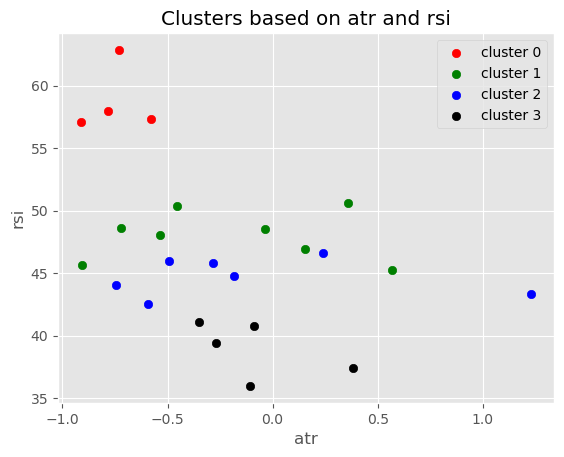

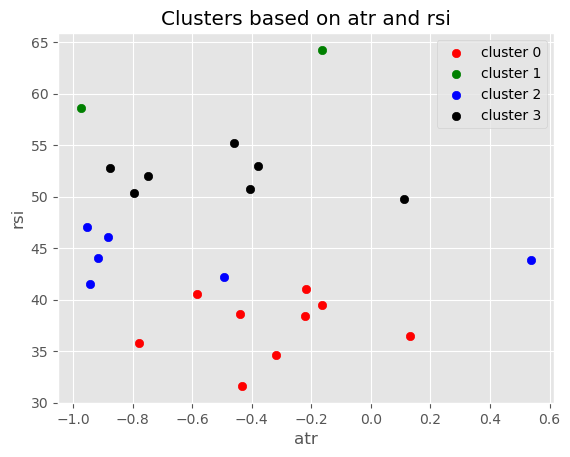

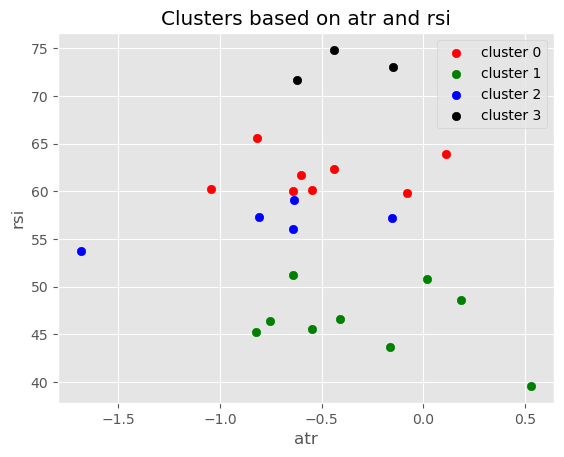

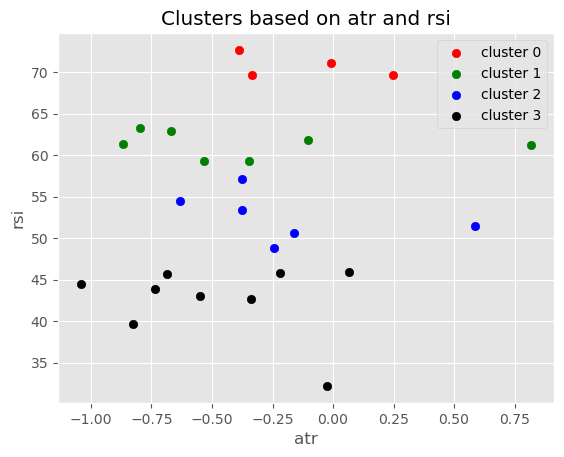

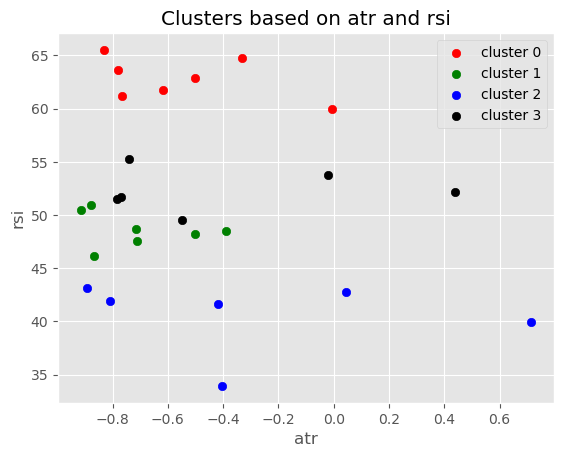

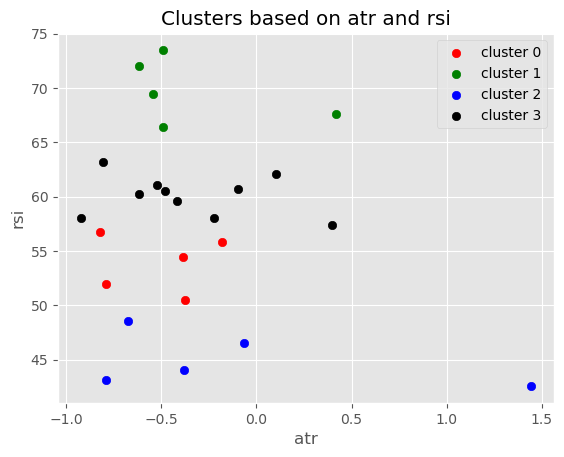

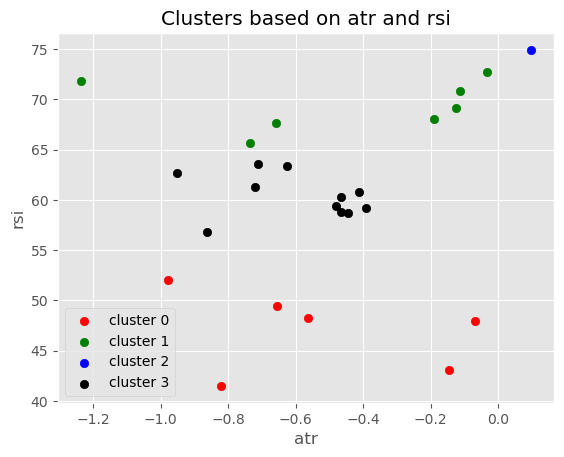

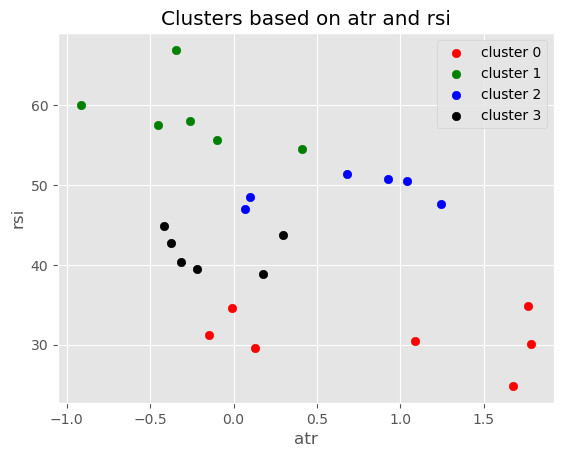

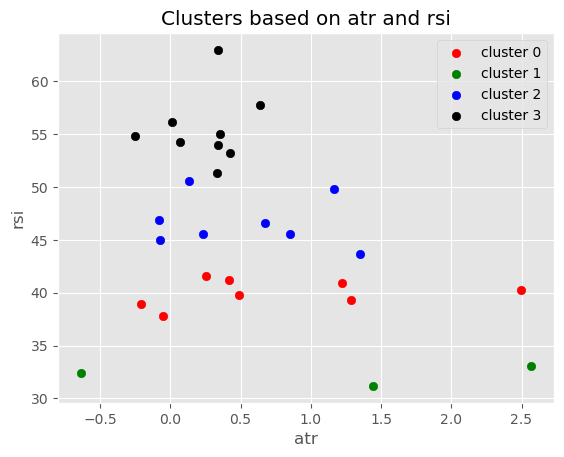

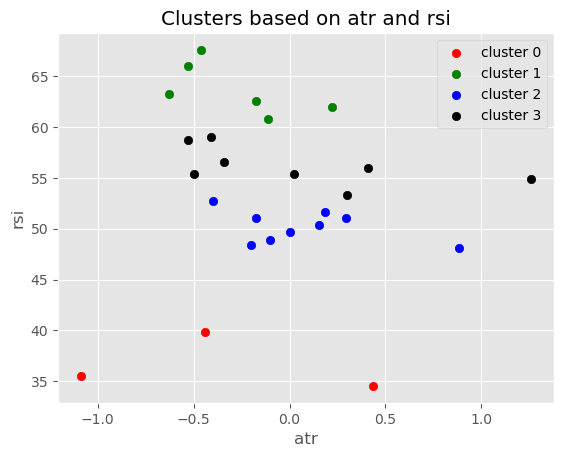

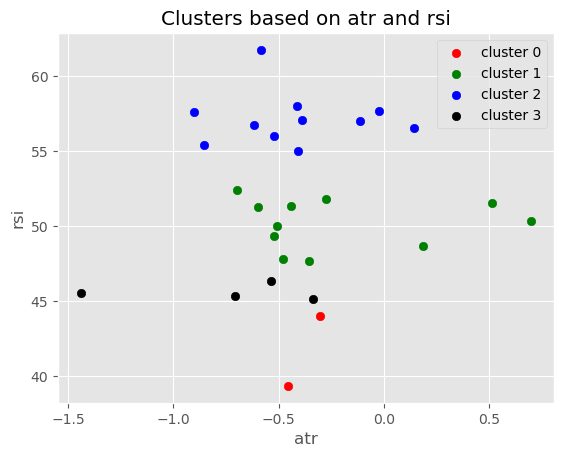

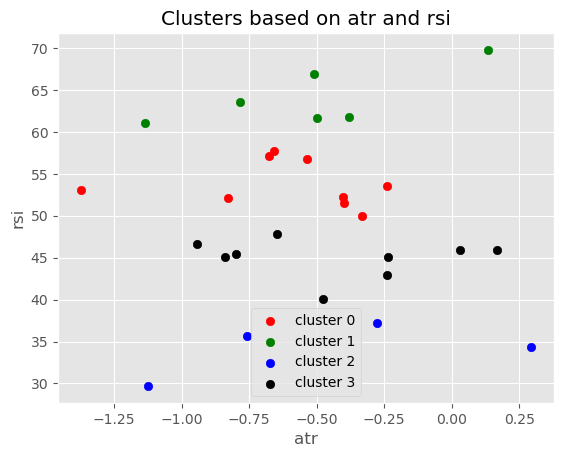

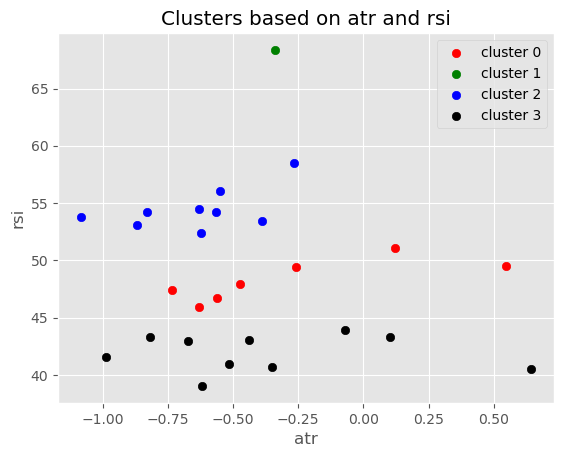

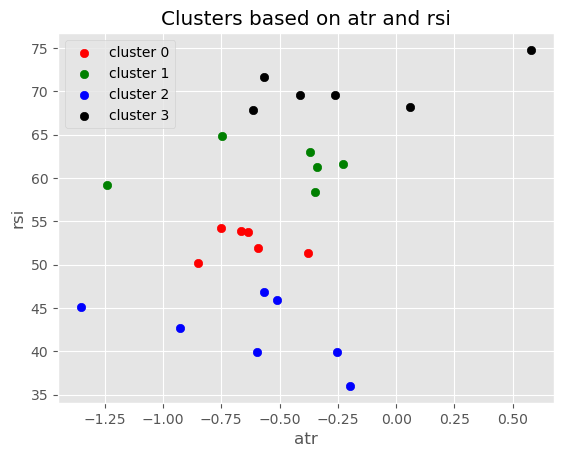

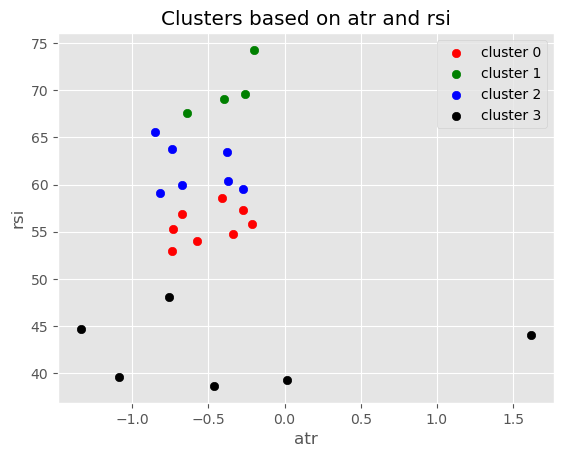

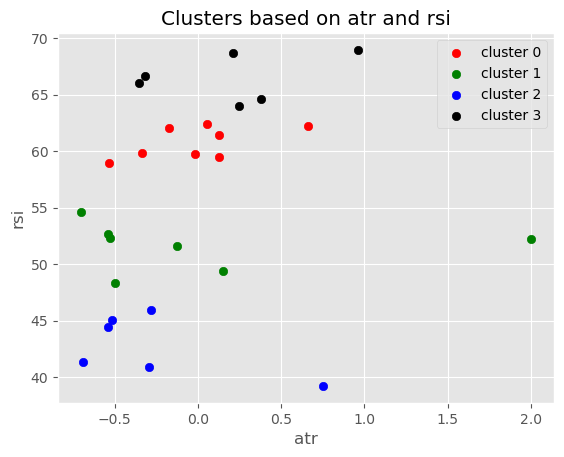

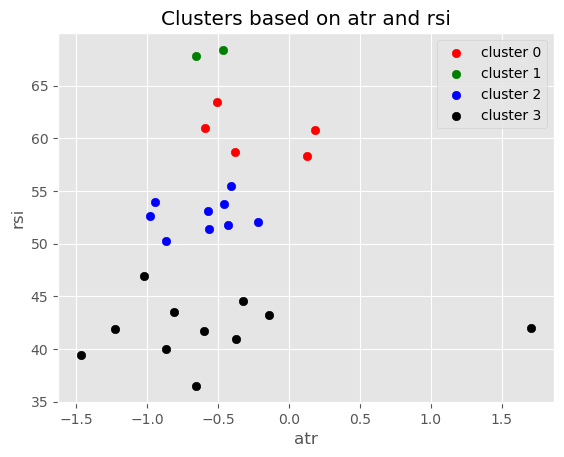

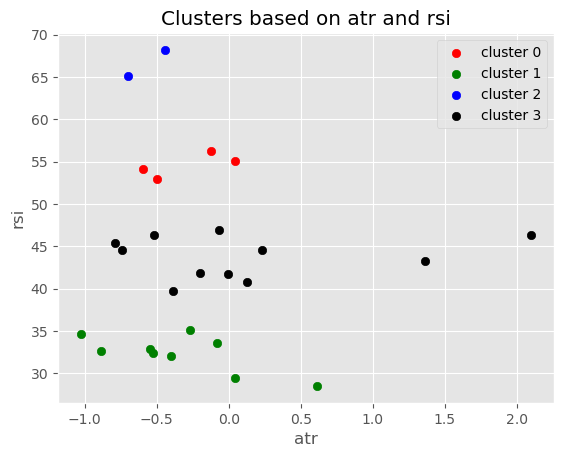

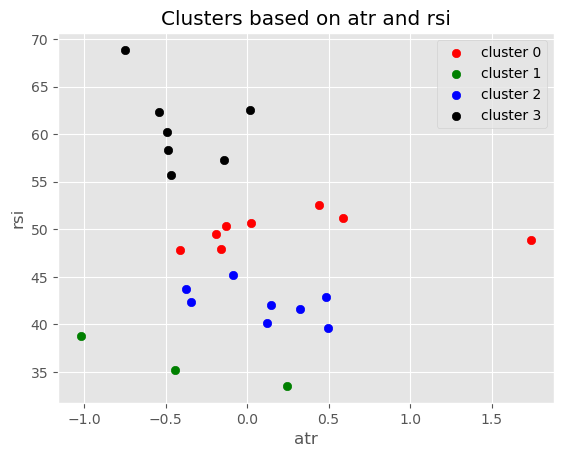

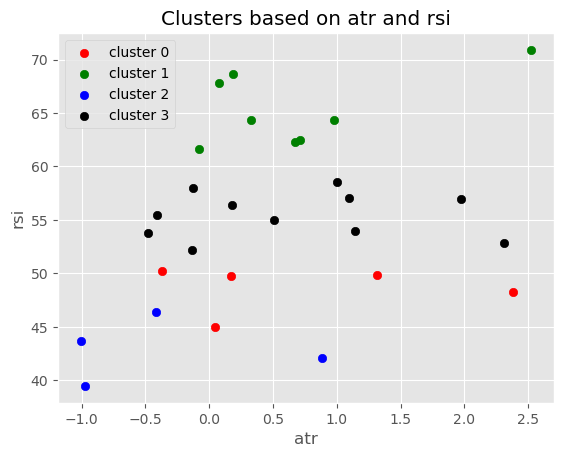

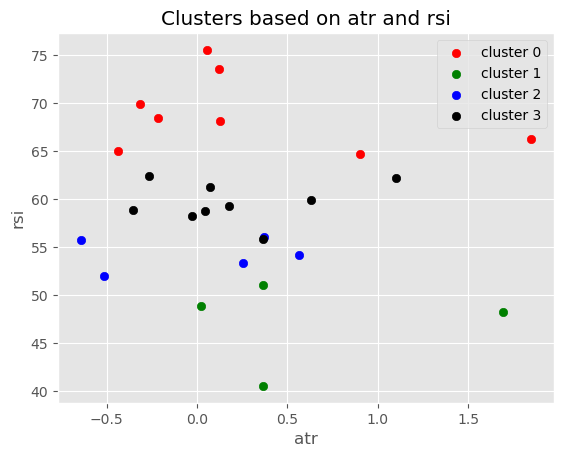

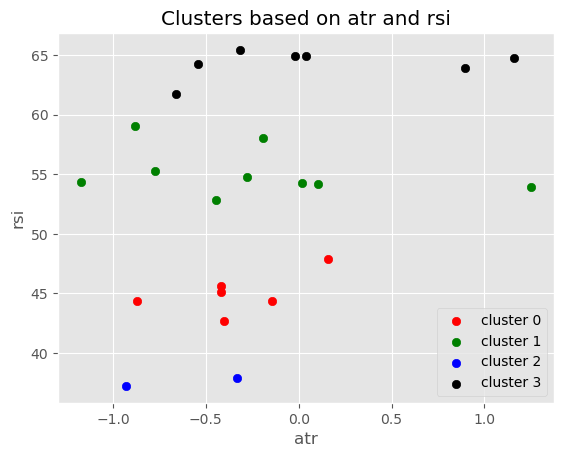

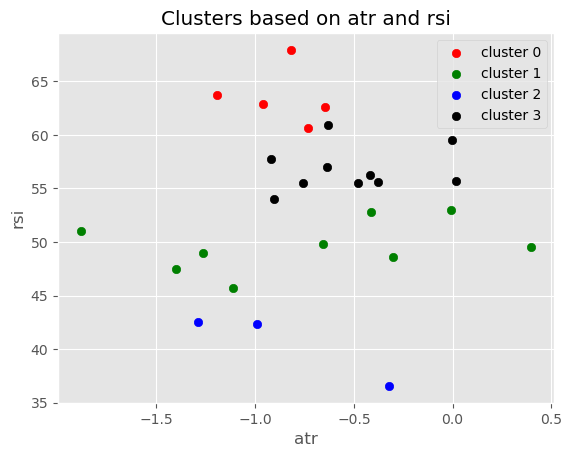

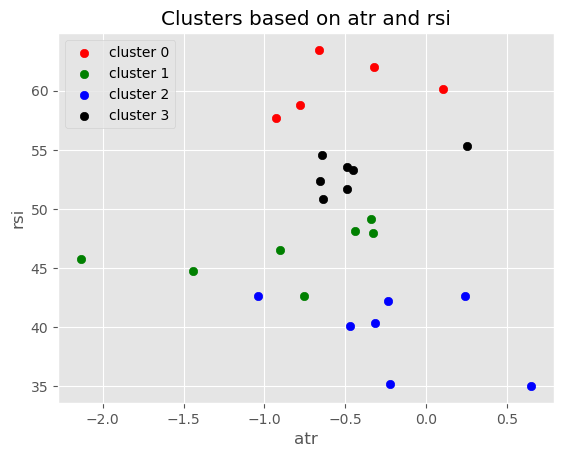

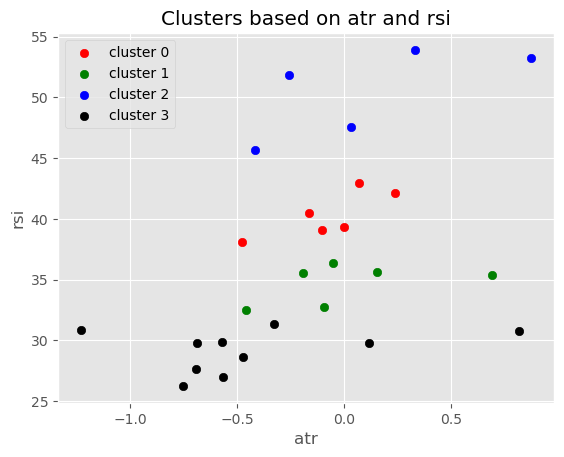

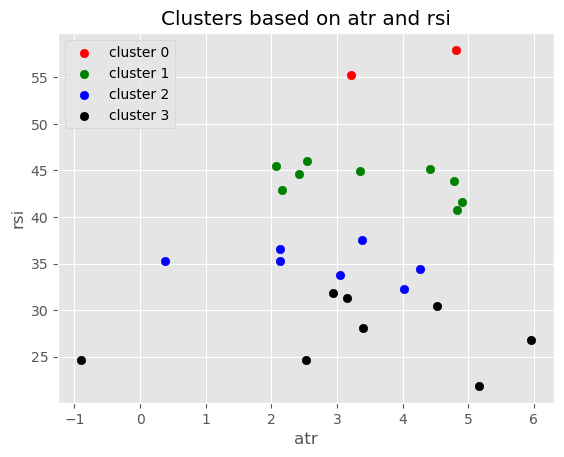

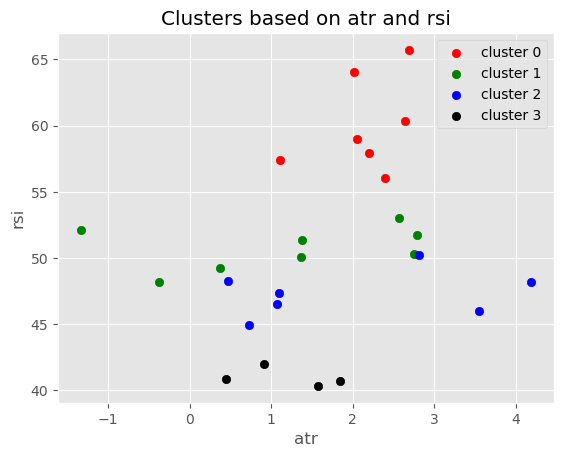

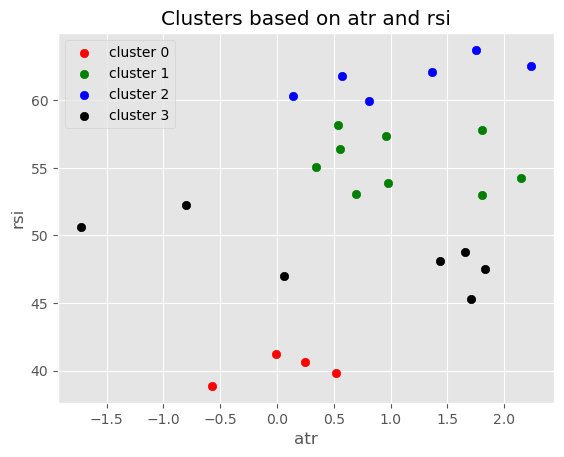

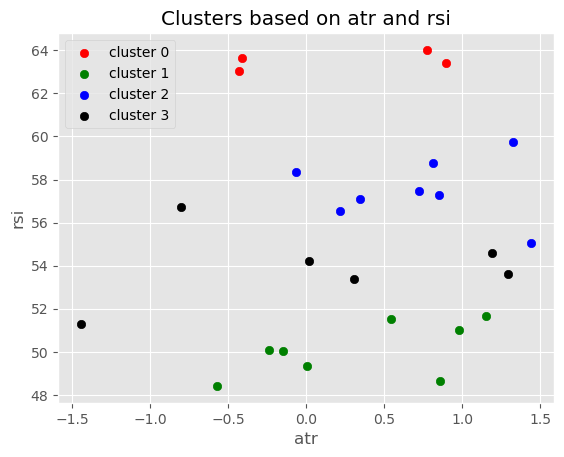

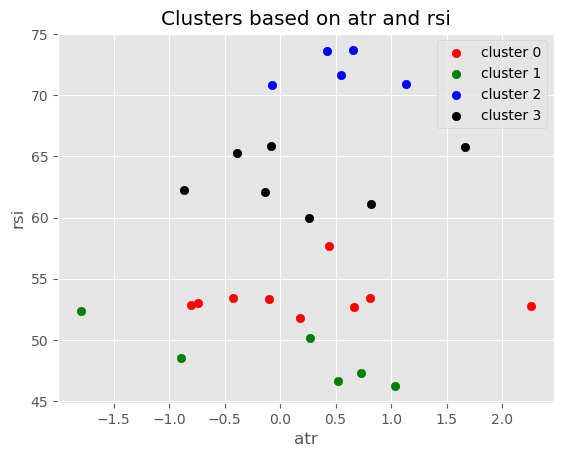

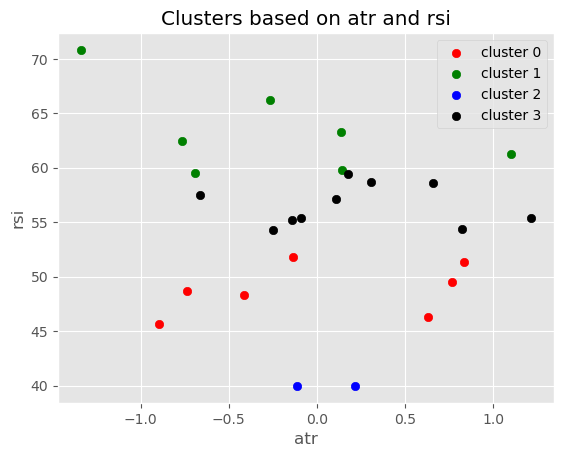

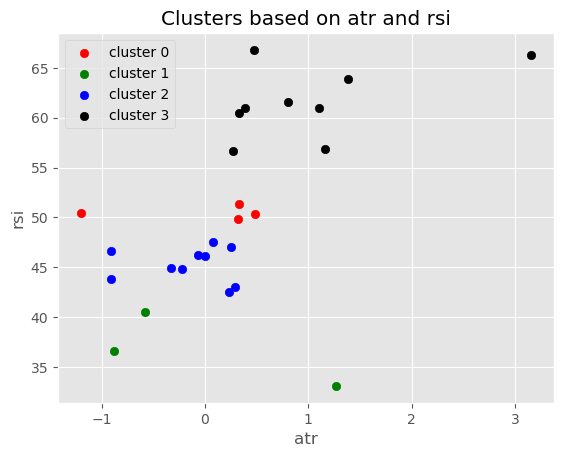

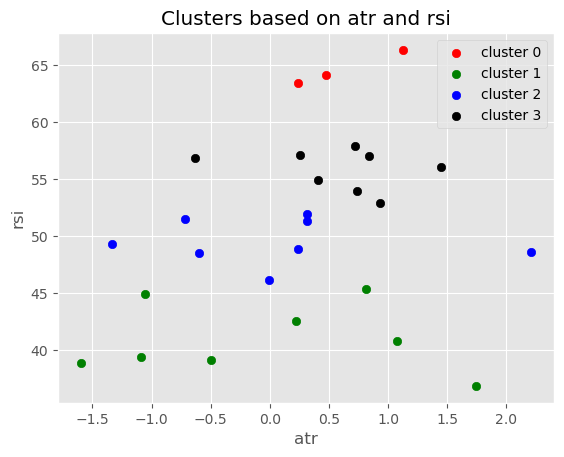

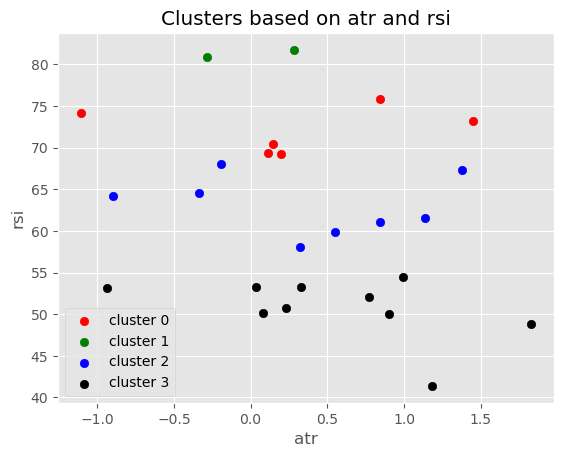

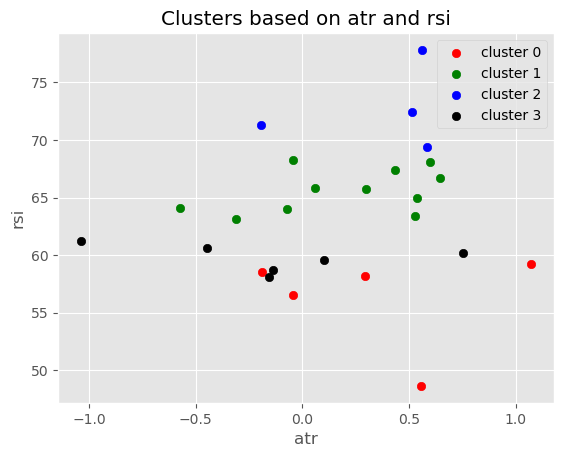

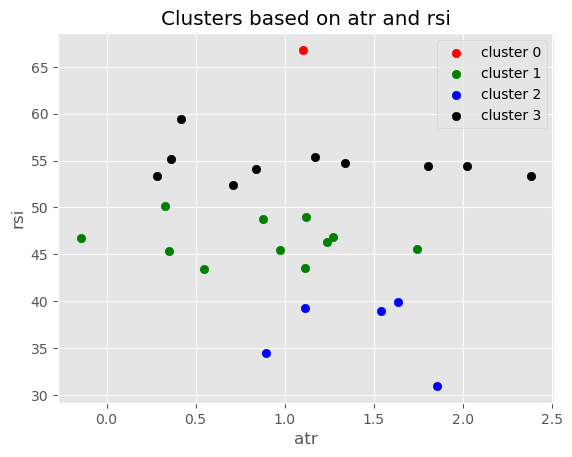

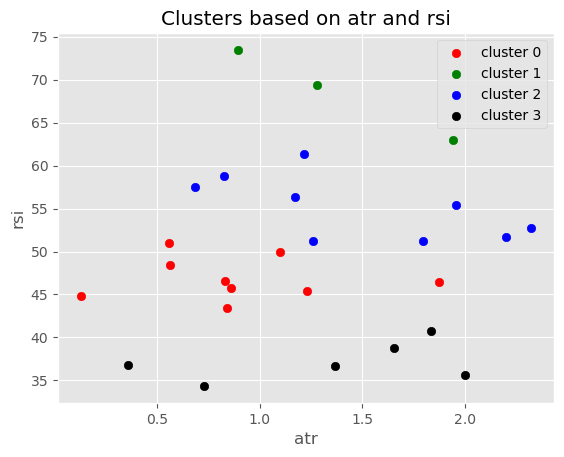

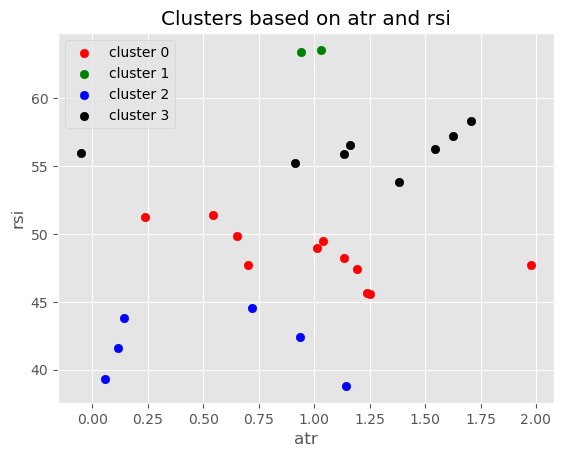

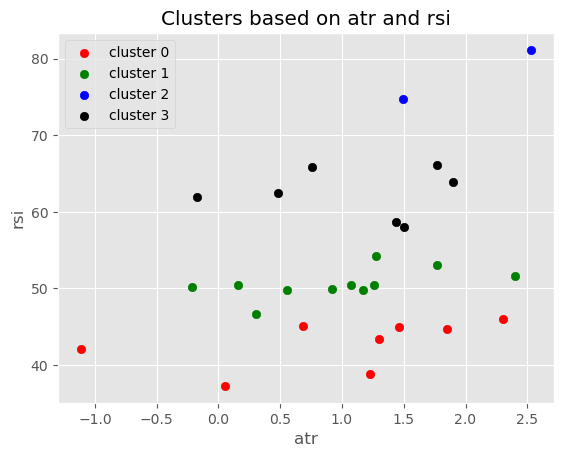

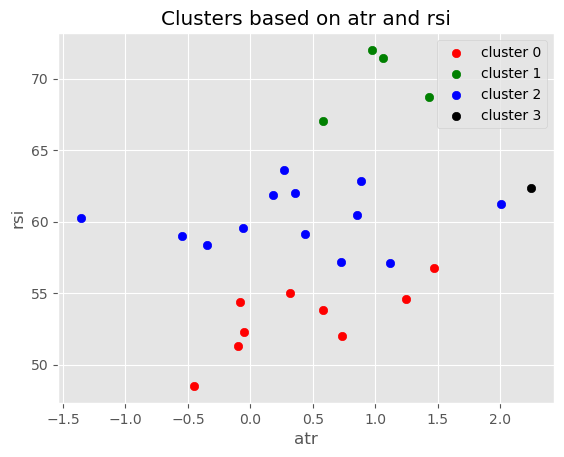

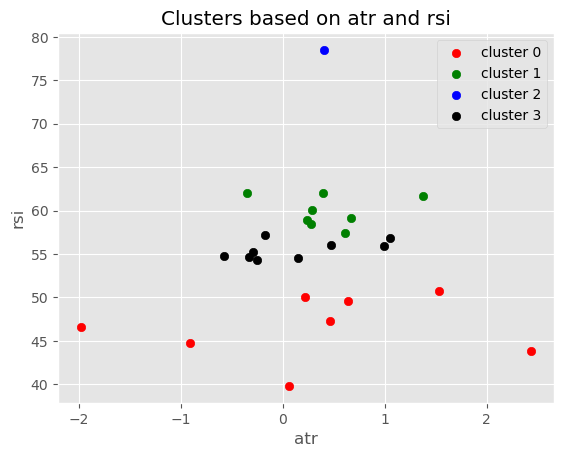

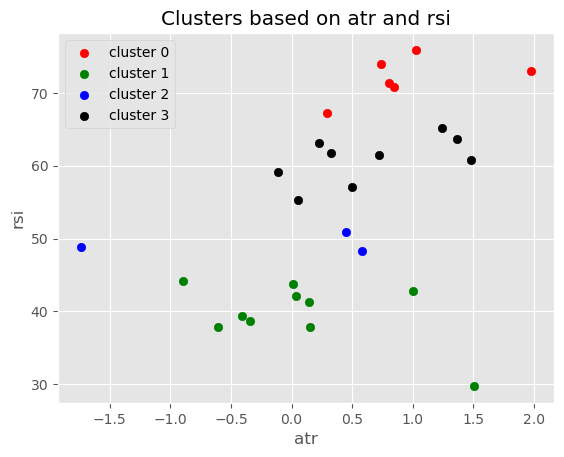

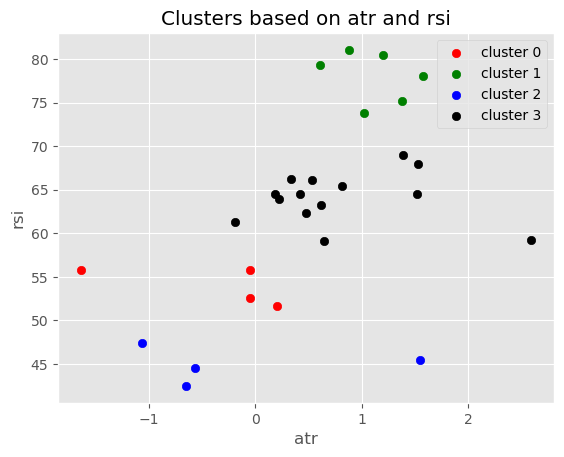

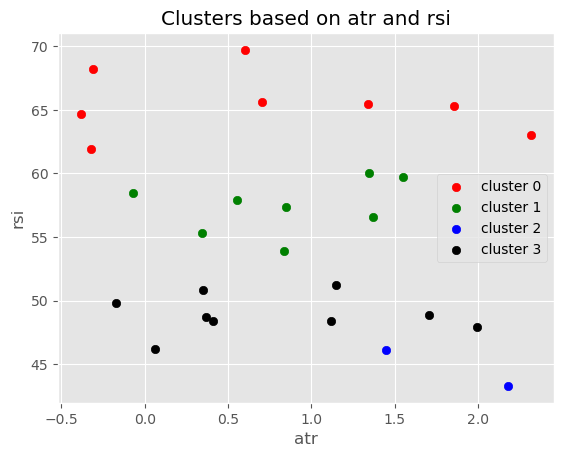

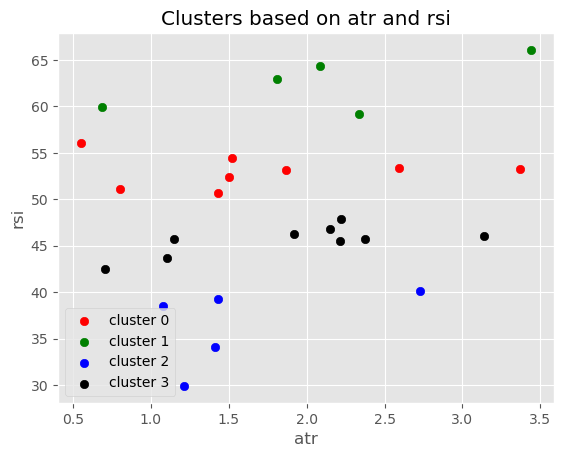

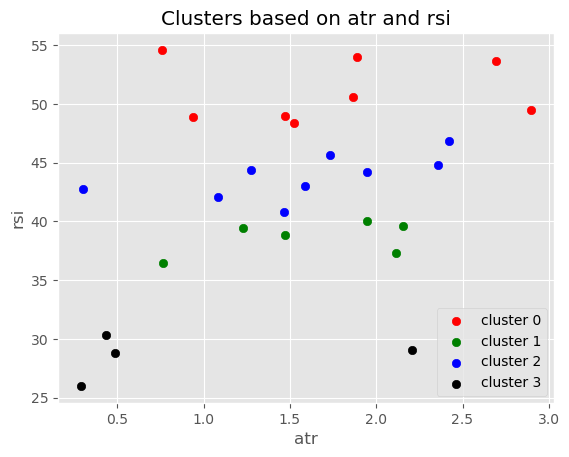

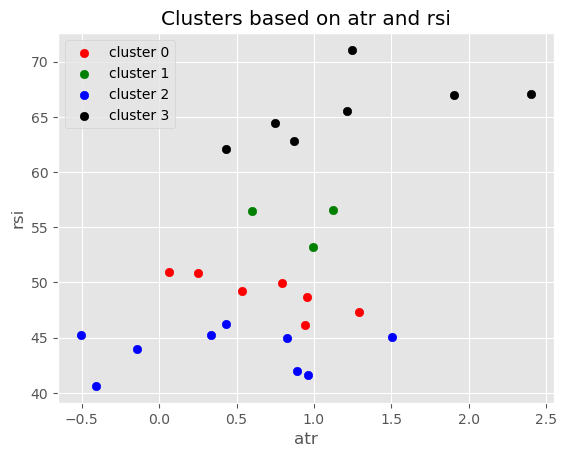

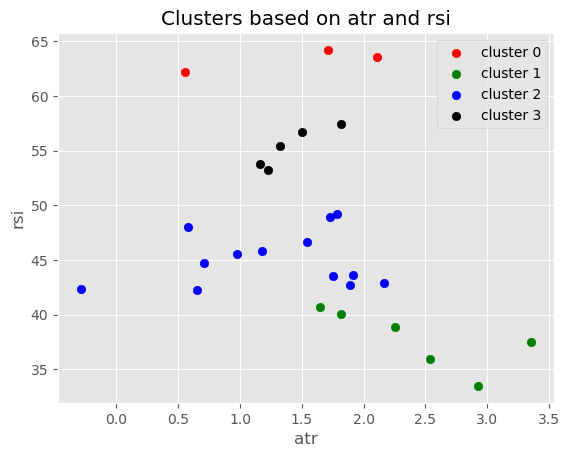

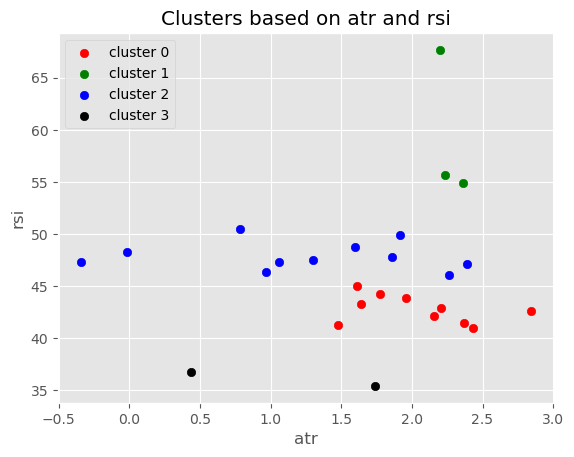

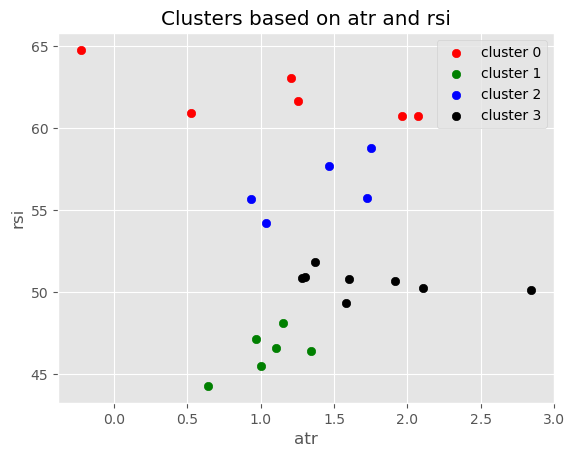

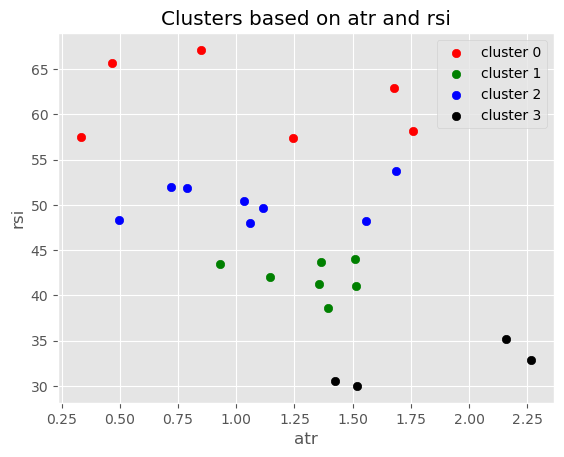

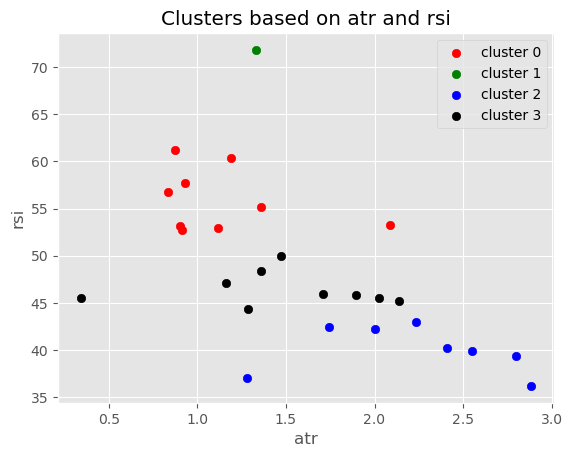

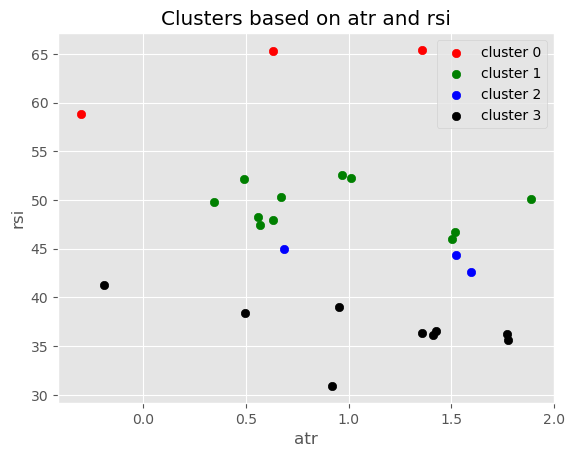

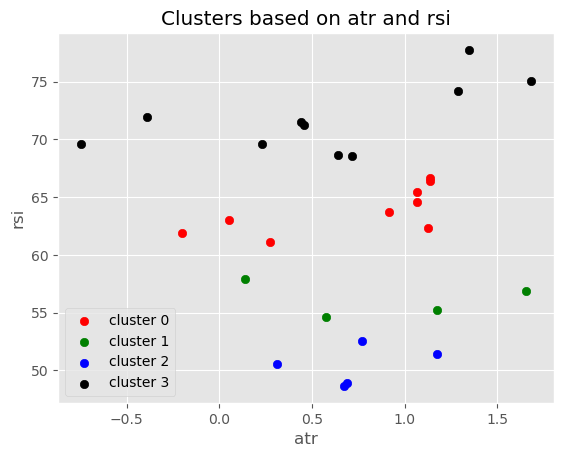

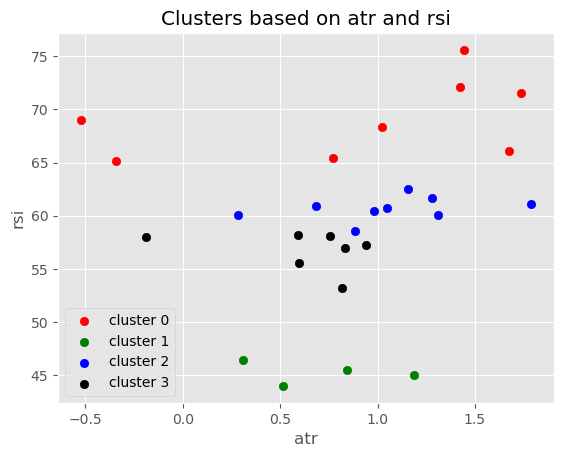

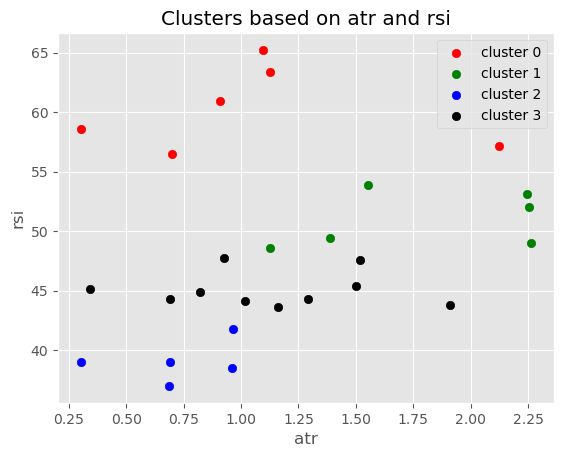

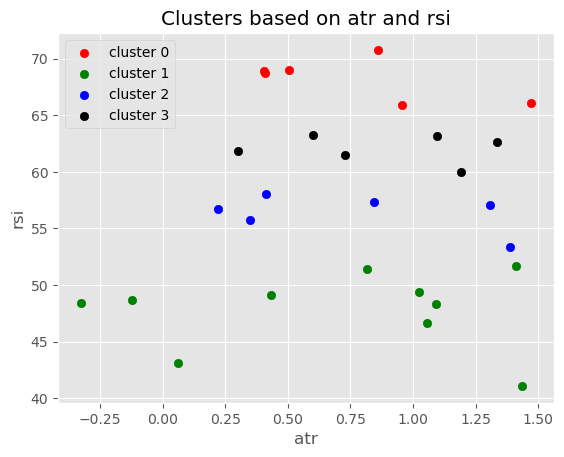

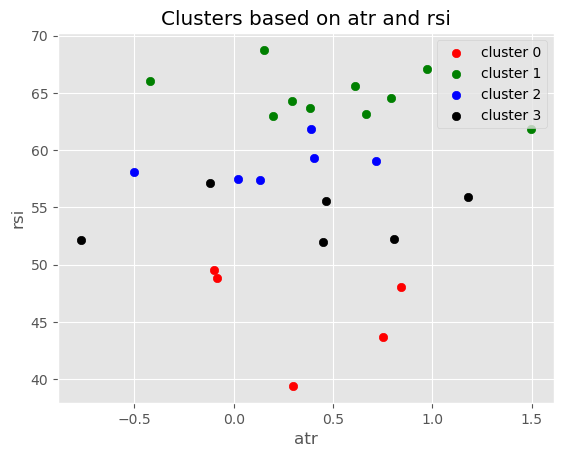

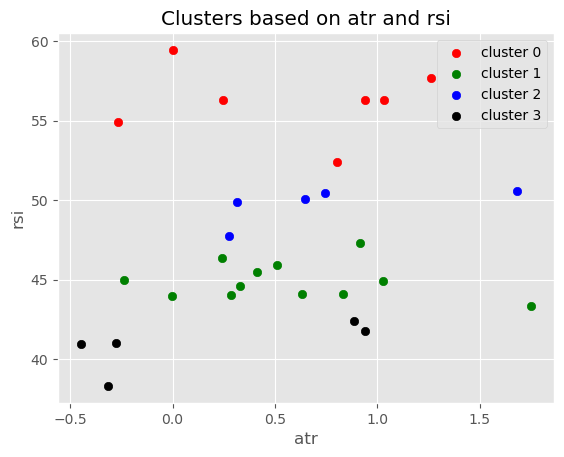

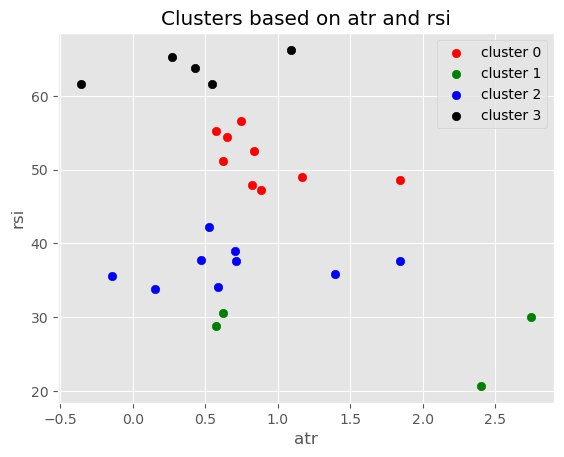

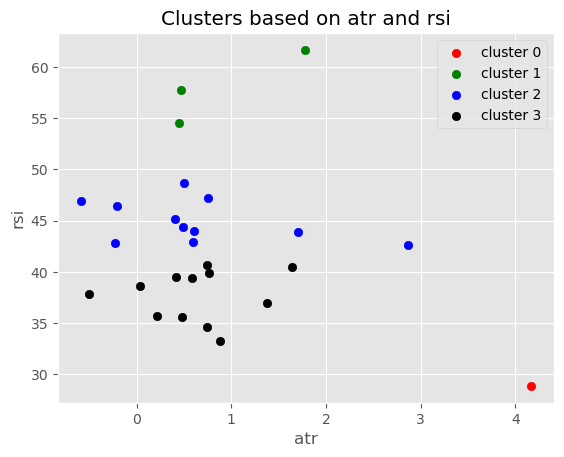

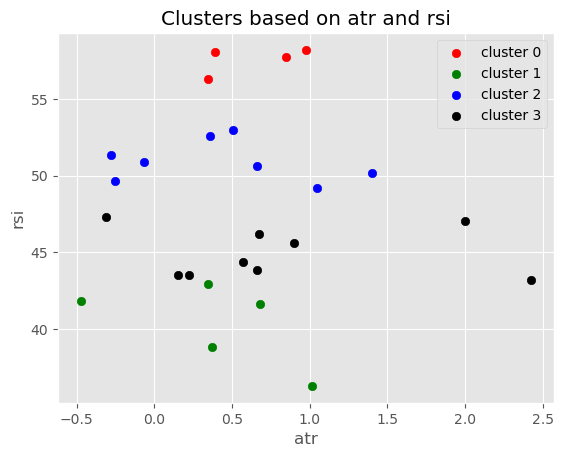

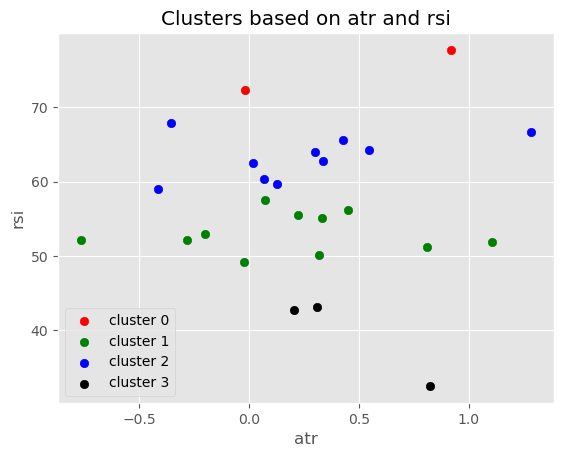

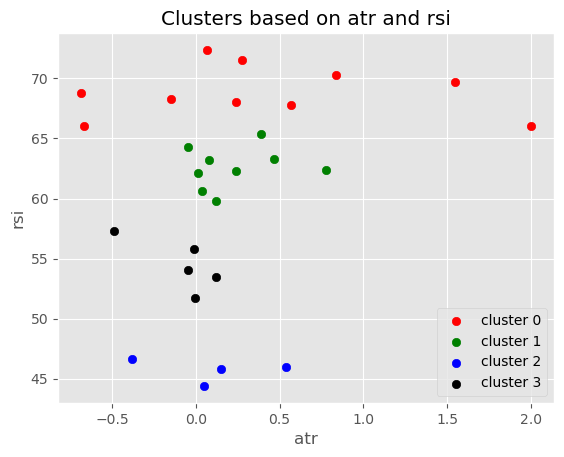

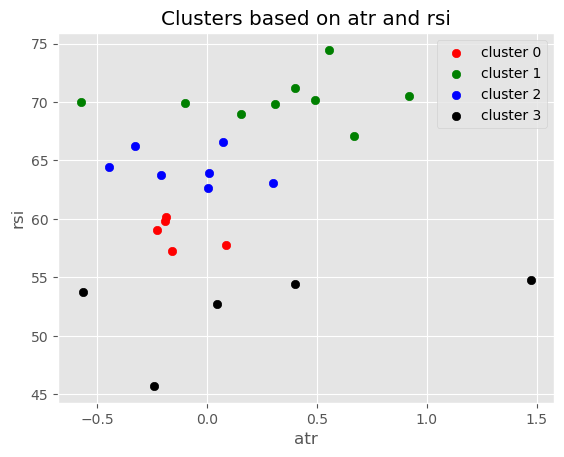

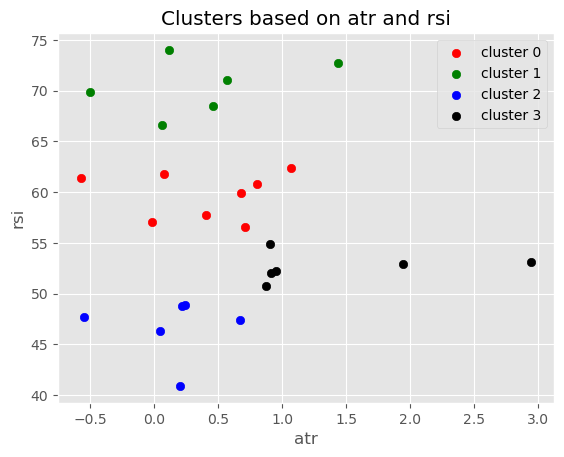

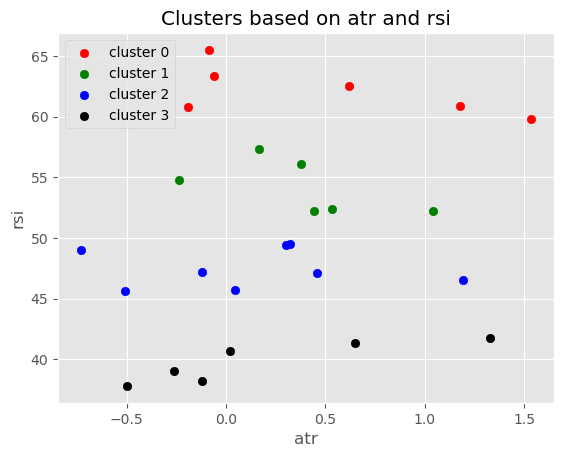

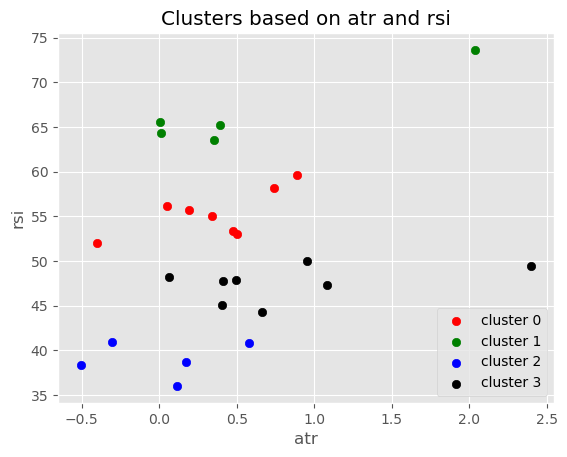

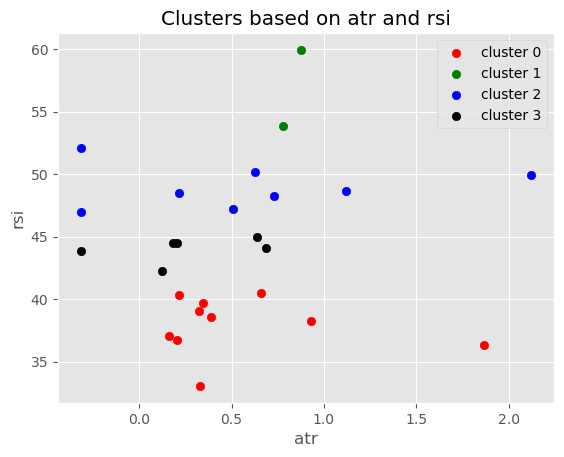

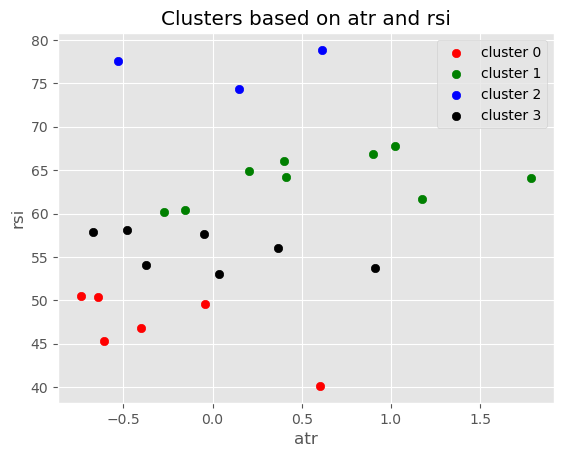

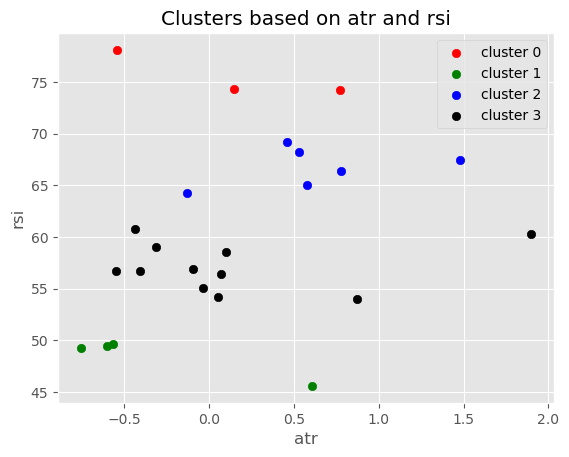

In [14]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

##  Apply pre-defined Centriods

In [15]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [16]:
 

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                           
2017-01-31 AXISBANK.NS           -0.000133  50.399413  6.069462  6.126097   
           HCLTECH.NS            -0.015487  45.978353  5.832812  5.859875   
           HDFCBANK.NS           -0.000721  67.618954  6.324470  6.379680   
           ICICIBANK.NS          -0.000131  55.501093  5.398469  5.444866   
           INDUSINDBK.NS         -0.000346  65.374094  6.966738  7.051620   
...                                    ...        ...       ...       ...   
2023-12-31 SBIN.NS                0.000063  49.651107  6.319633  6.349924   
           TATAMOTORS.NS          0.000059  66.415028  6.441771  6.509480   
           TATASTEEL.NS           0.000124  64.266803  4.763704  4.823854   
           TCS.NS                 0.000029  55.050007  8.096111  8.138220   
           ULTRACEMCO.NS          0.000200  65.031393  9.041387  9.071900   

                           bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                              
2017-01-31 AXISBANK.NS    6.182732 -0.969123 -0.003962   0.035671  -0.004105   
           HCLTECH.NS     5.886938 -0.842721 -0.111814  -0.020291   0.004562   
           HDFCBANK.NS    6.434890 -1.250302  0.417261   0.066697   0.035648   
           ICICIBANK.NS   5.491263 -1.258358 -0.057291   0.053467   0.006381   
           INDUSINDBK.NS  7.136502 -0.784808  1.036651   0.130111   0.073411   
...                            ...       ...       ...        ...        ...   
2023-12-31 SBIN.NS        6.380216 -0.564773 -0.500317   0.012395   0.005466   
           TATAMOTORS.NS  6.577189  0.780300  1.497726  -0.001345   0.059324   
           TATASTEEL.NS   4.884004 -0.130349  0.657966   0.016419   0.046297   
           TCS.NS         8.180330 -0.037020  0.266461   0.006896   0.020989   
           ULTRACEMCO.NS  9.102412  0.574442  1.069452   0.072617   0.046121   

                          return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                       
2017-01-31 AXISBANK.NS    -0.014518  -0.026105  -0.000481    0.011840   
           HCLTECH.NS      0.020541   0.015019   0.011301   -0.003492   
           HDFCBANK.NS     0.007254   0.005338   0.015217    0.017787   
           ICICIBANK.NS   -0.009604   0.003799   0.016473    0.014789   
           INDUSINDBK.NS   0.014311   0.010549   0.020340    0.025552   
...                             ...        ...        ...         ...   
2023-12-31 SBIN.NS        -0.015153  -0.000320   0.011952   -0.004287   
           TATAMOTORS.NS   0.038315   0.029161   0.059455    0.051365   
           TATASTEEL.NS    0.002837   0.025150   0.028220    0.014721   
           TCS.NS         -0.000743   0.011172   0.011587    0.009042   
           ULTRACEMCO.NS   0.030426   0.037862   0.034033    0.041435   

                            Mkt-RF       SMB       HML       RMW       CMA  \
date       ticker                                                            
2017-01-31 AXISBANK.NS    0.858693  0.195109  0.388702 -0.425679  0.043703   
           HCLTECH.NS     0.950129 -0.609863  0.185233 -0.261602  0.071314   
           HDFCBANK.NS    0.459674  0.359985  0.130553 -0.035833  0.222566   
           ICICIBANK.NS   0.729474 -0.673049  0.795082 -0.308013 -0.443778   
           INDUSINDBK.NS  1.021786  0.274579  0.372826 -1.013550 -0.028237   
...                            ...       ...       ...       ...       ...   
2023-12-31 SBIN.NS        0.263798 -0.674279  0.584002  0.017712 -0.183759   
           TATAMOTORS.NS  0.951465 -0.399586  0.824621 -0.055839 -0.909591   
           TATASTEEL.NS   0.924705  0.417283 -0.346779 -0.353718  0.499817   
           TCS.NS         0.500000  0.121058  0.003154  0.214219  0.115056   
           ULTRACEMCO.NS  0.896897  0.448609  0.411564  0.716966 -0.587123   

                  

In [17]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return

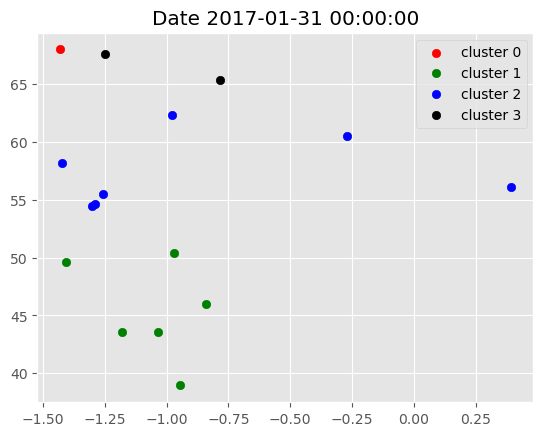

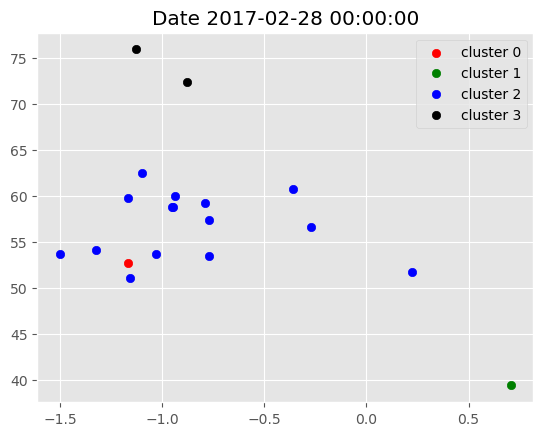

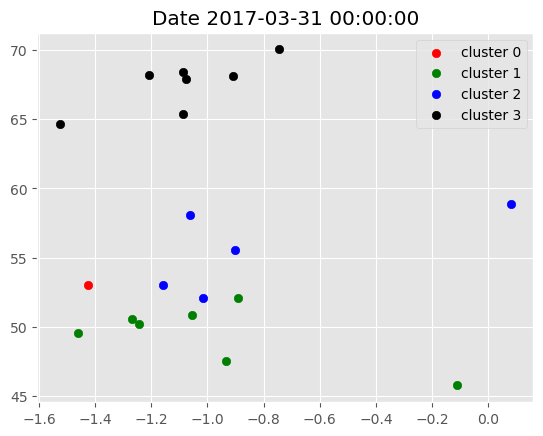

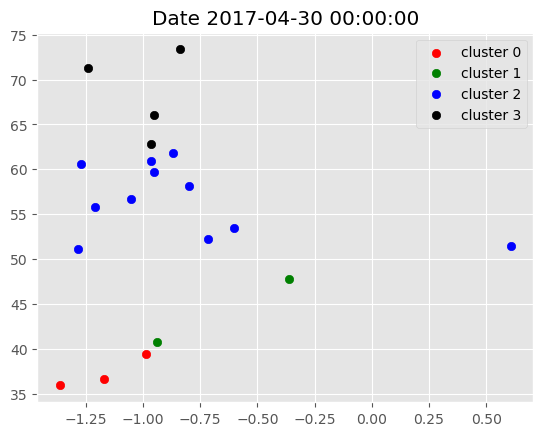

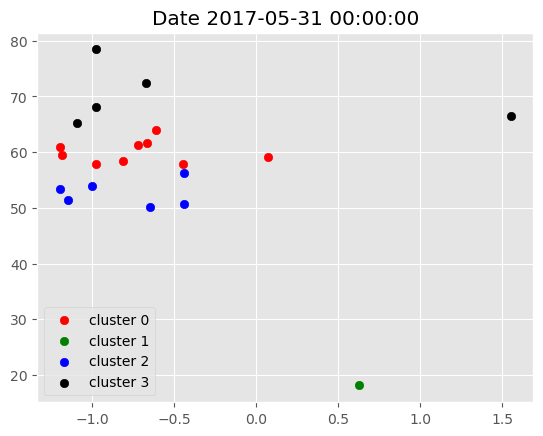

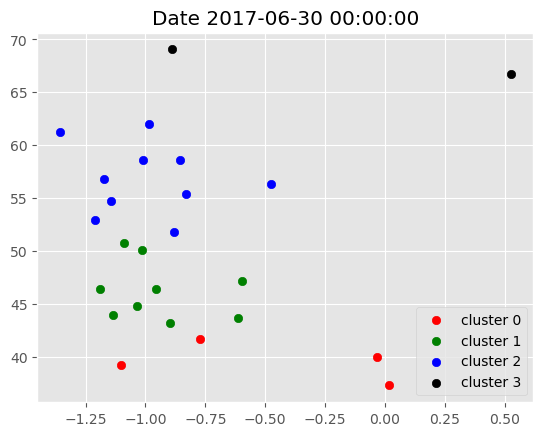

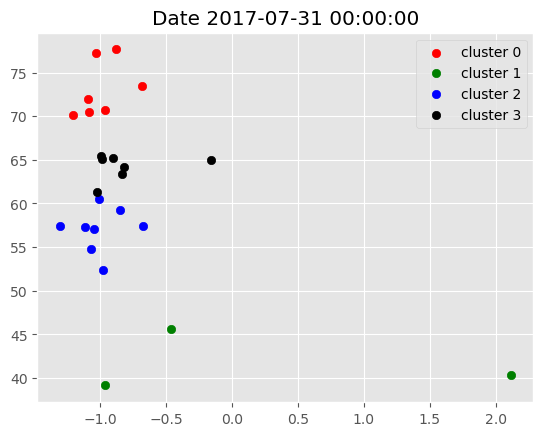

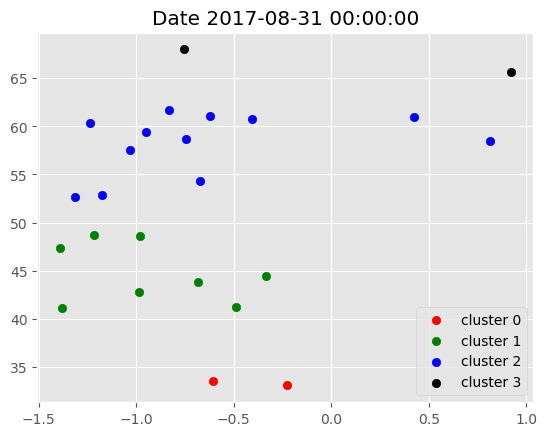

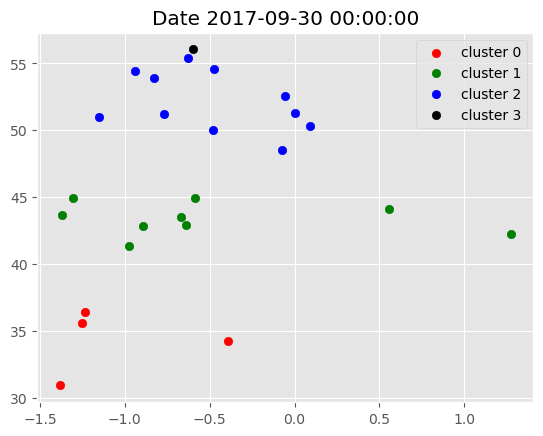

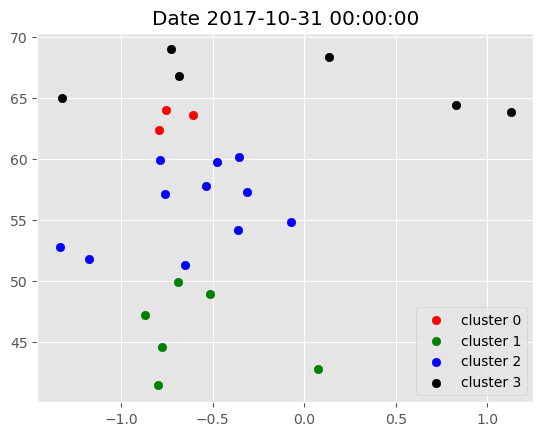

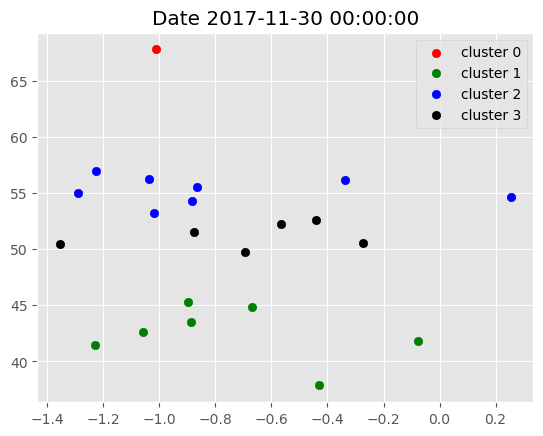

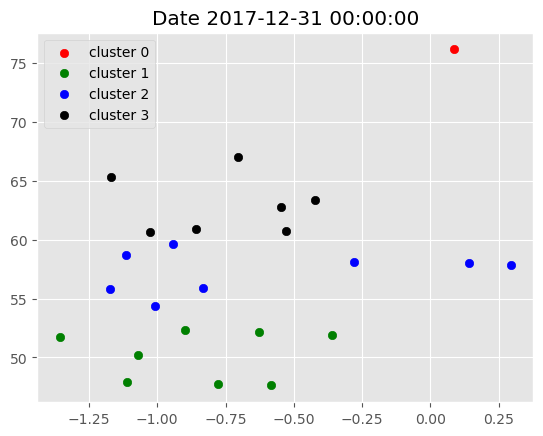

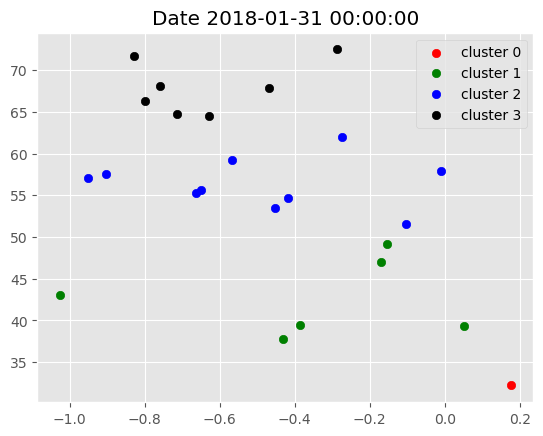

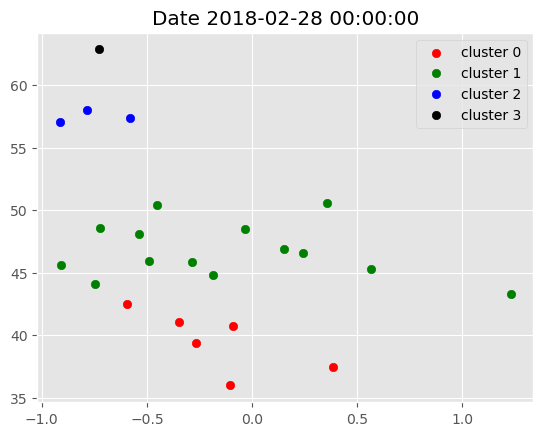

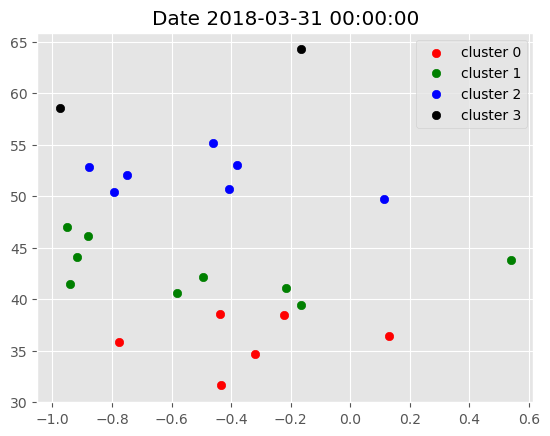

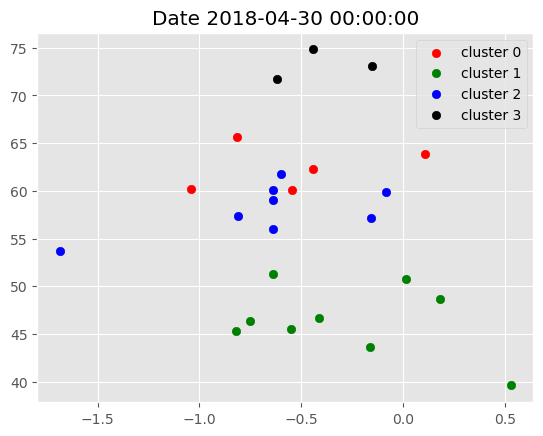

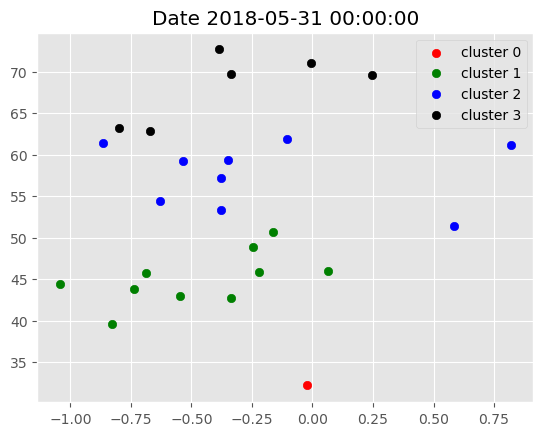

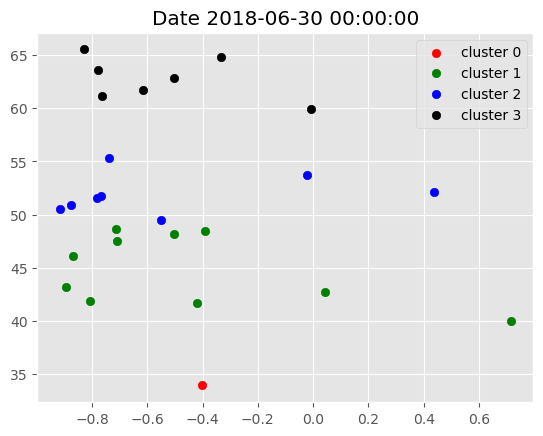

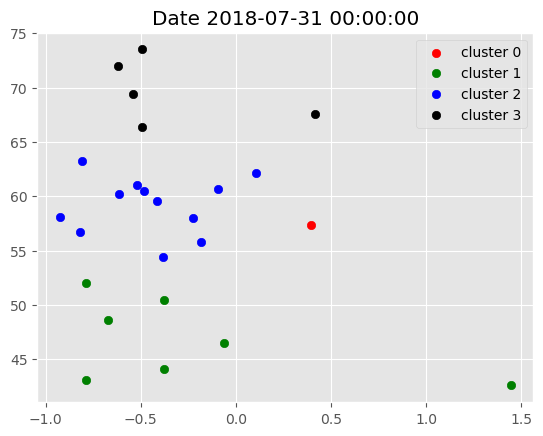

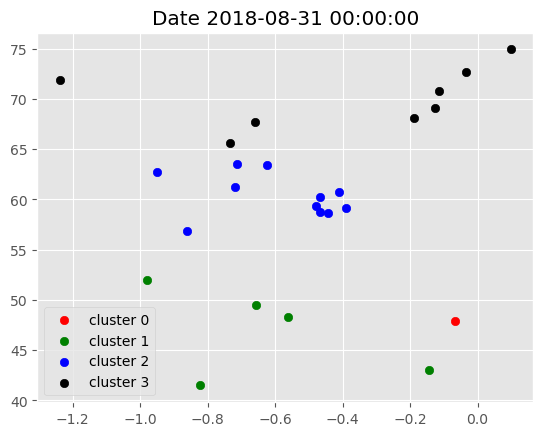

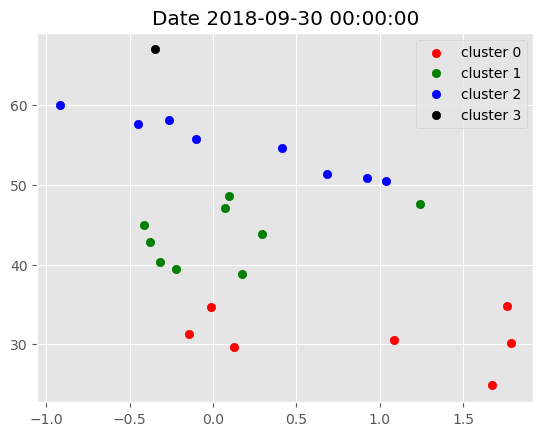

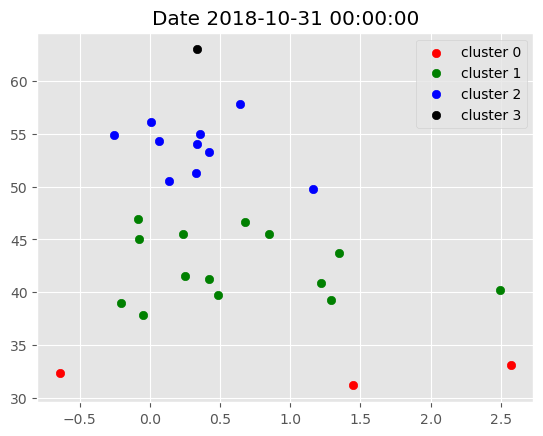

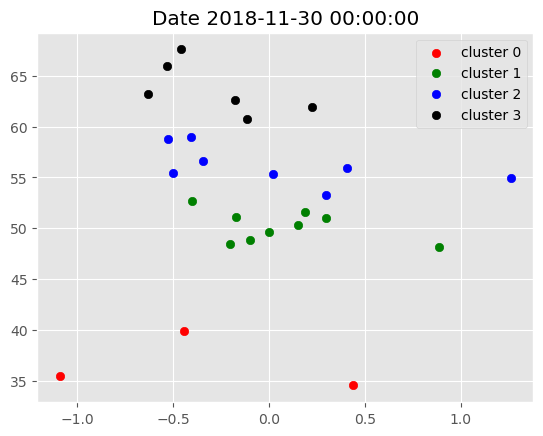

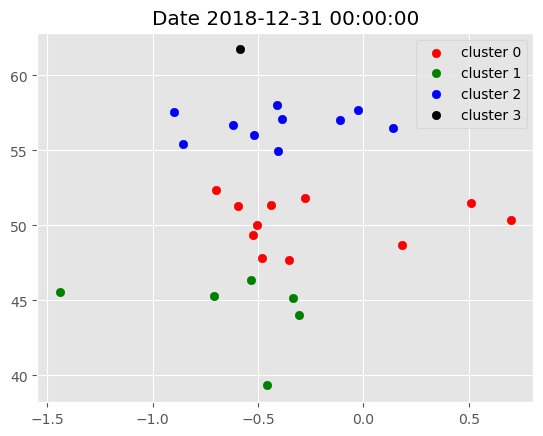

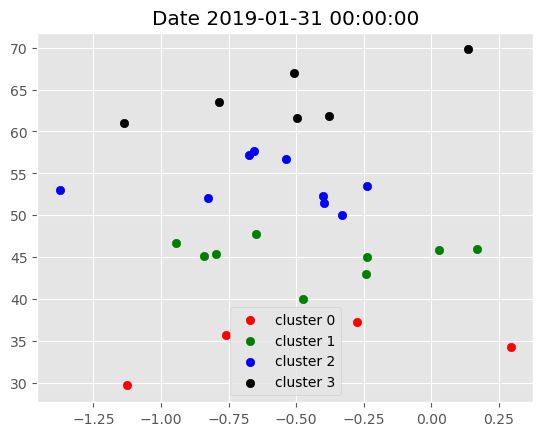

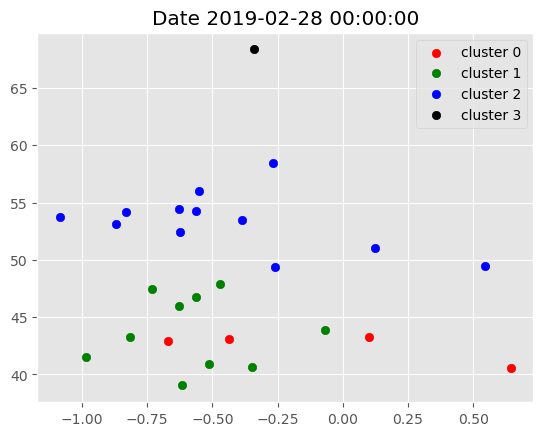

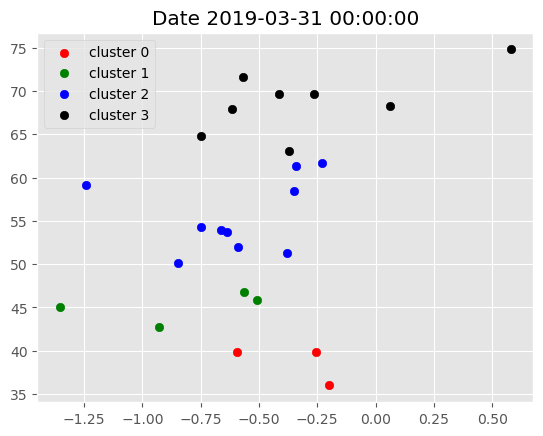

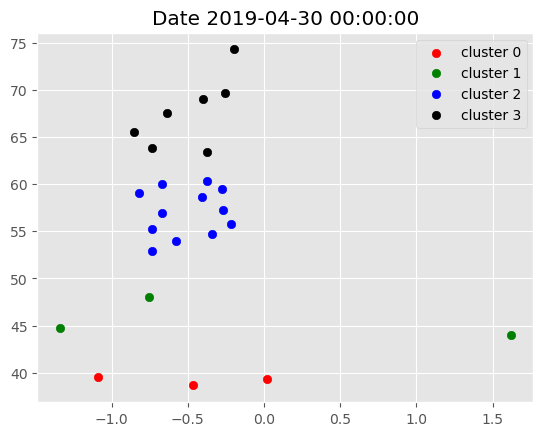

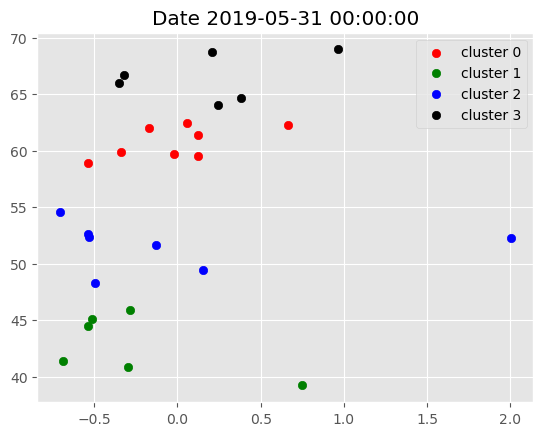

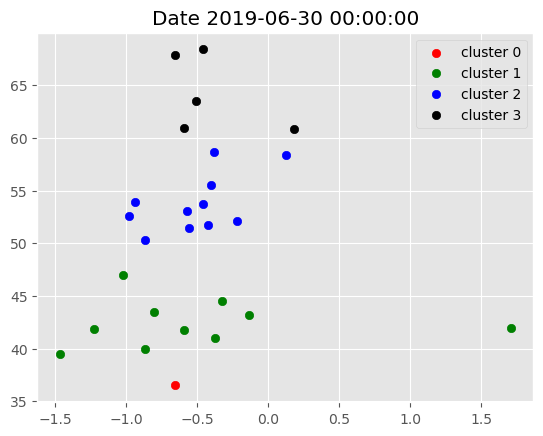

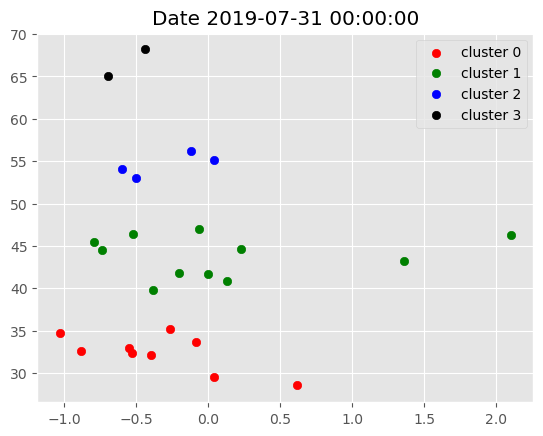

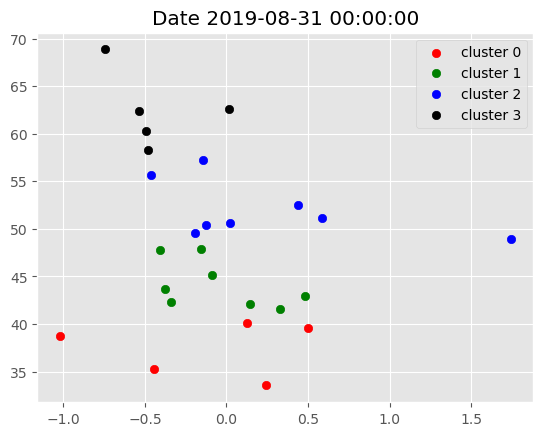

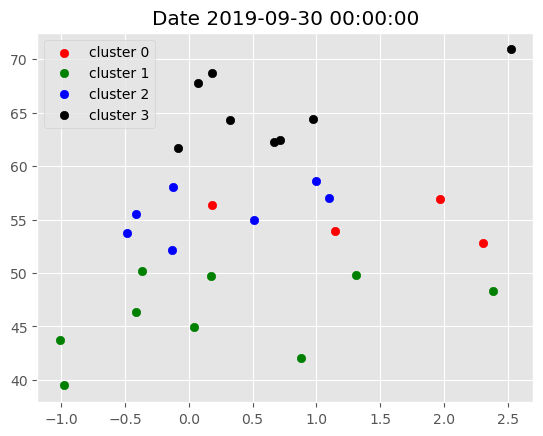

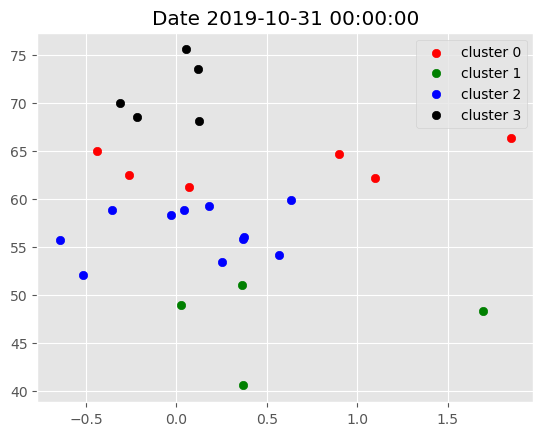

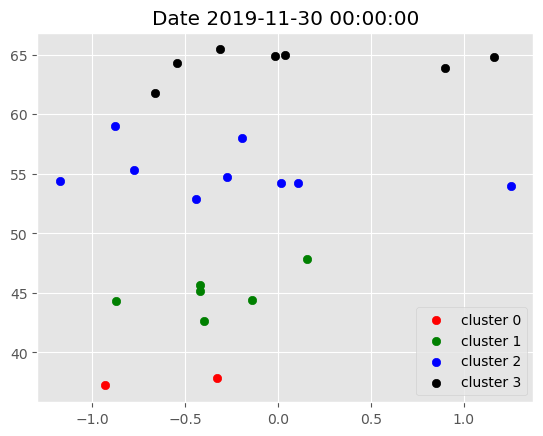

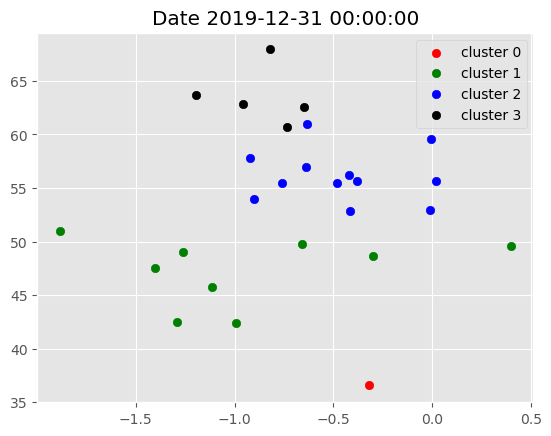

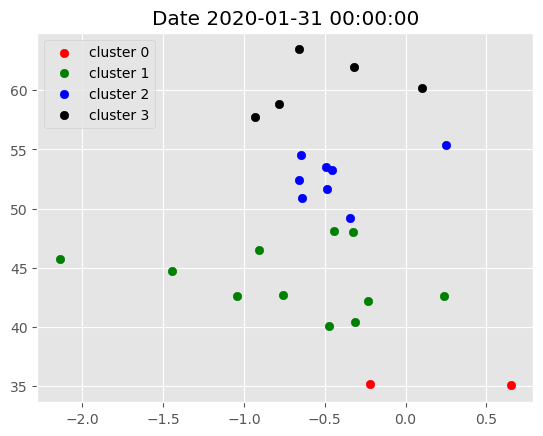

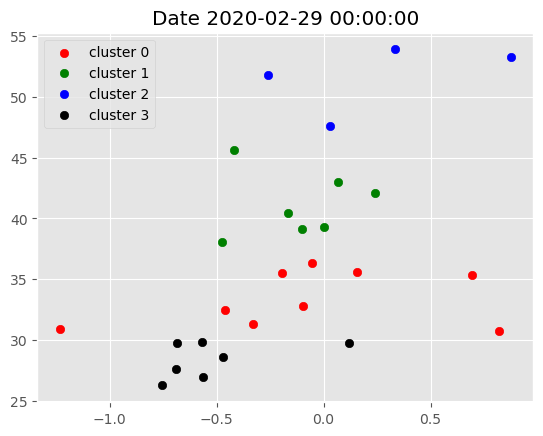

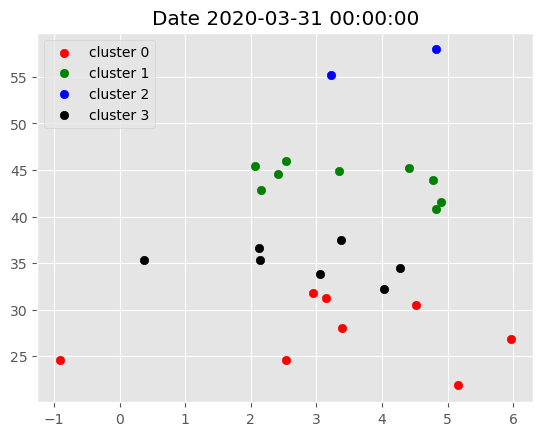

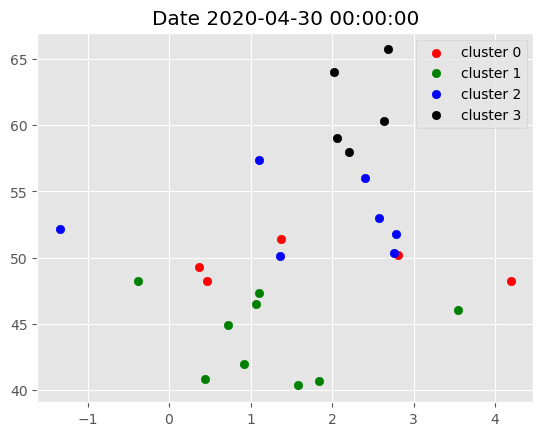

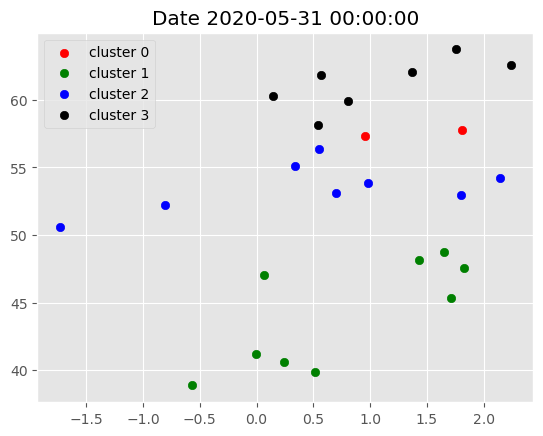

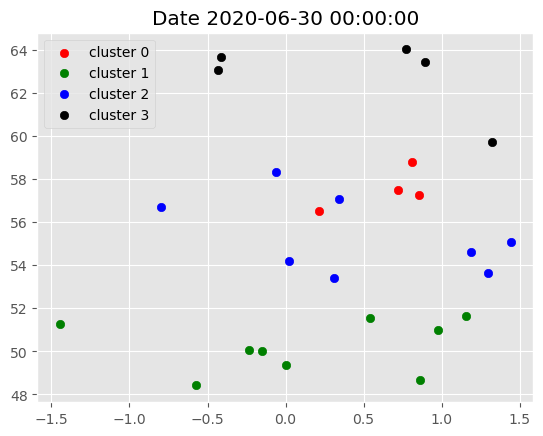

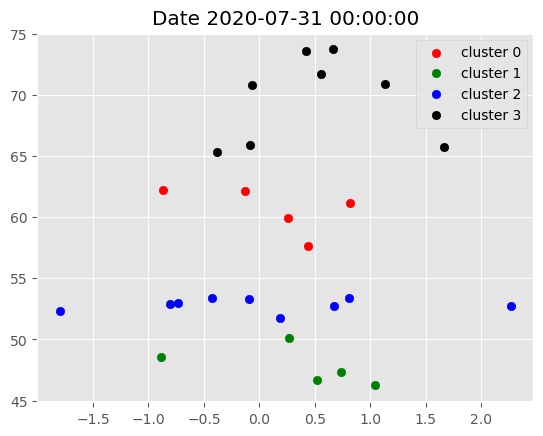

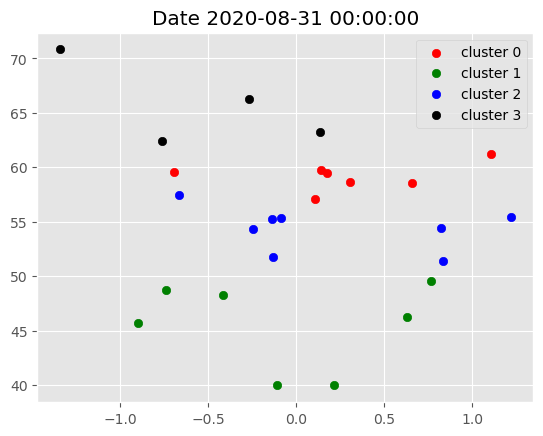

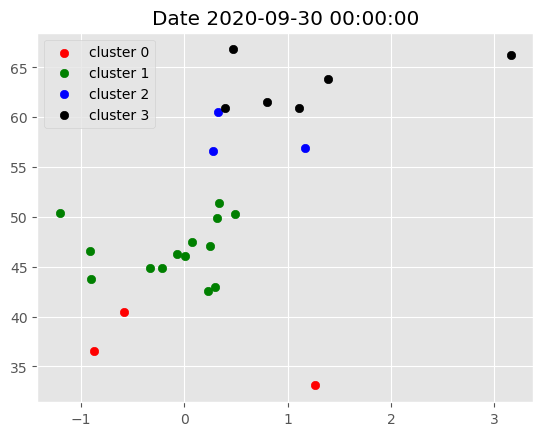

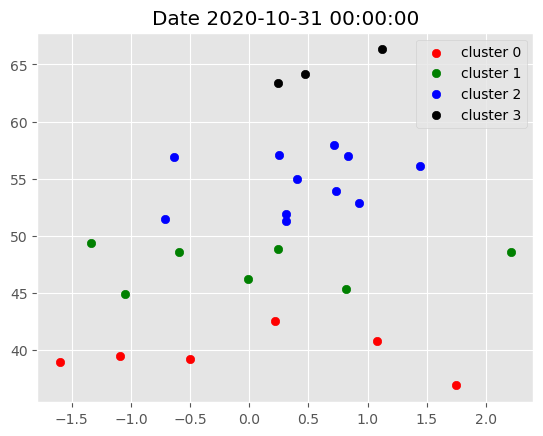

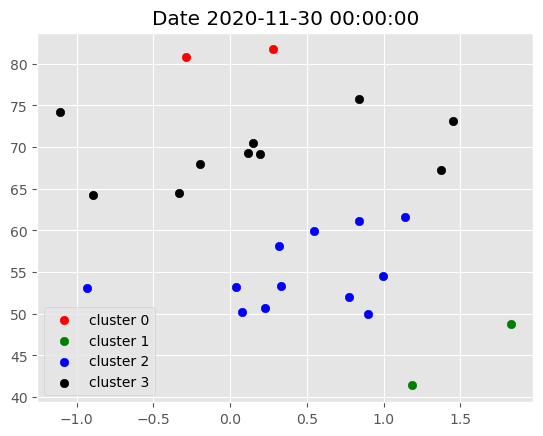

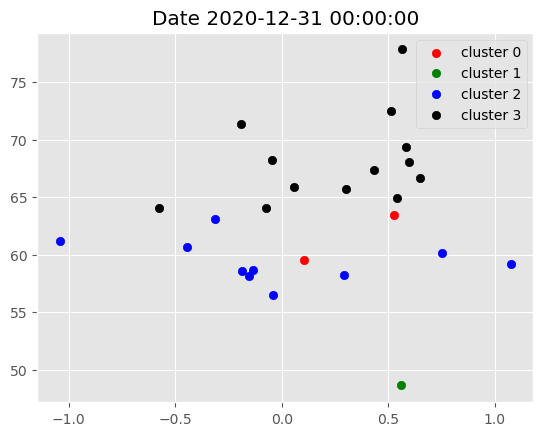

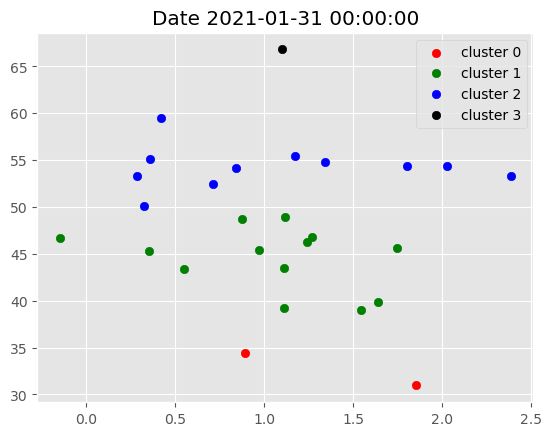

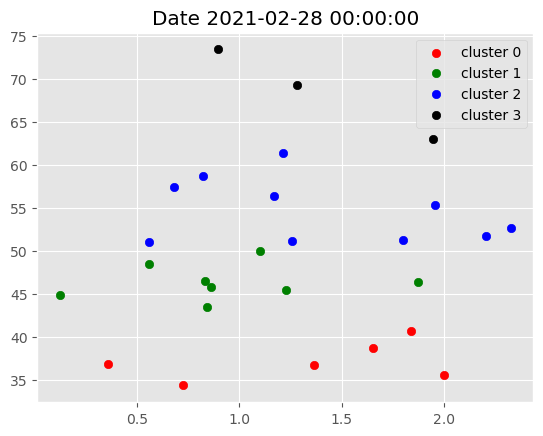

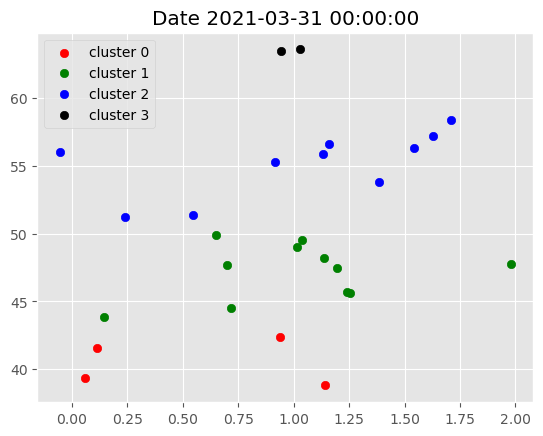

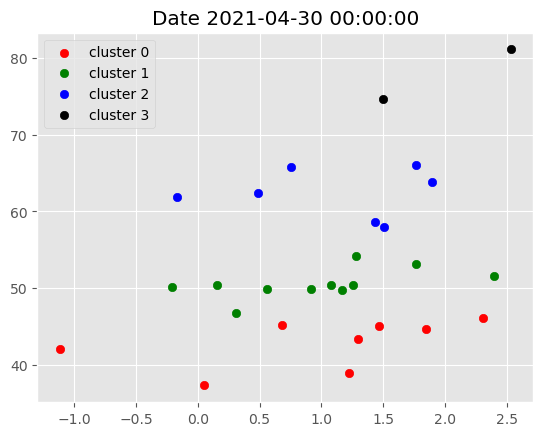

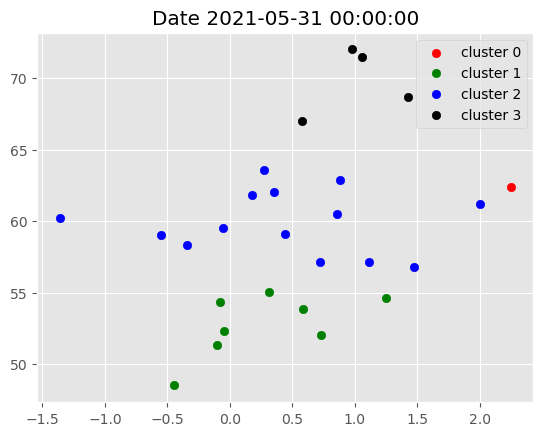

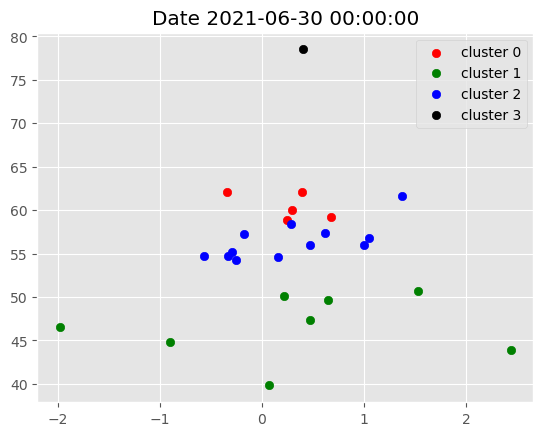

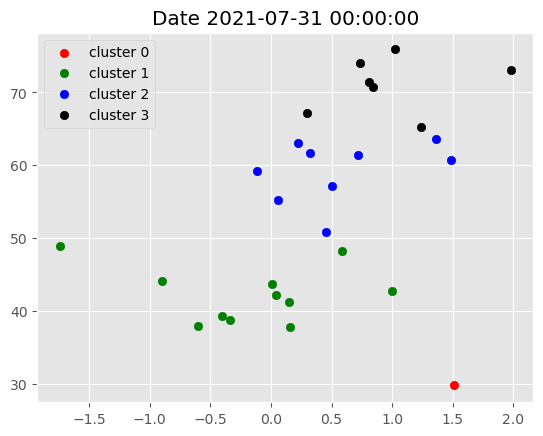

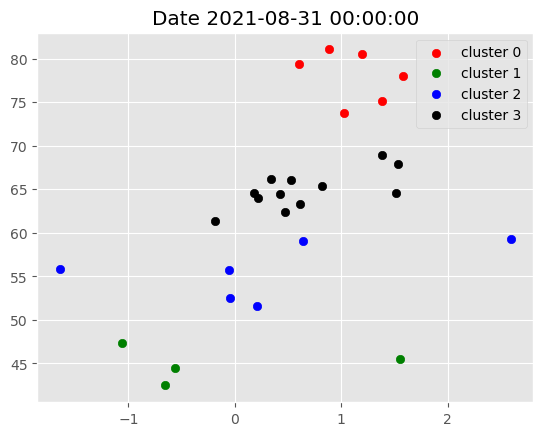

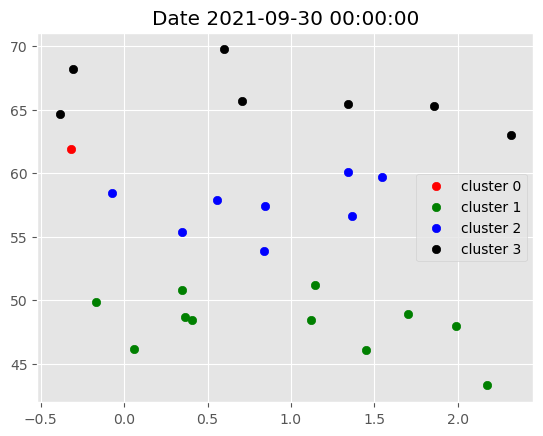

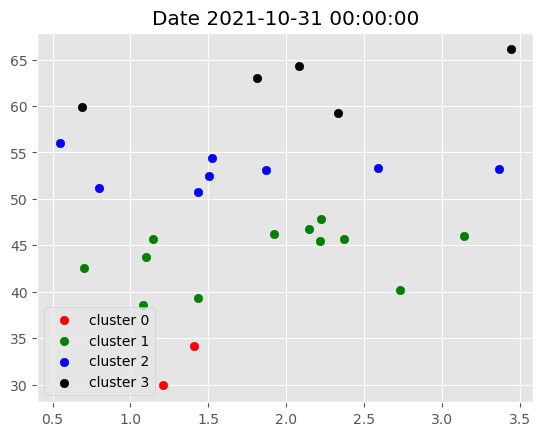

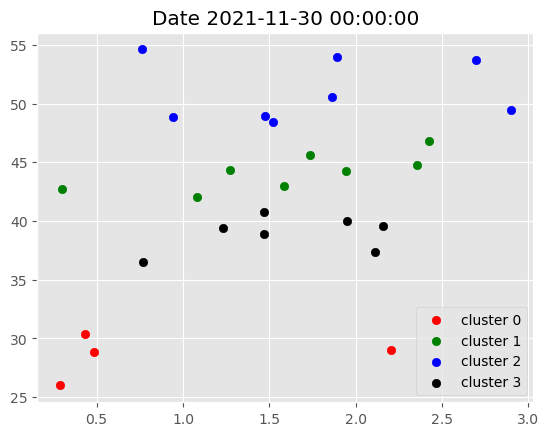

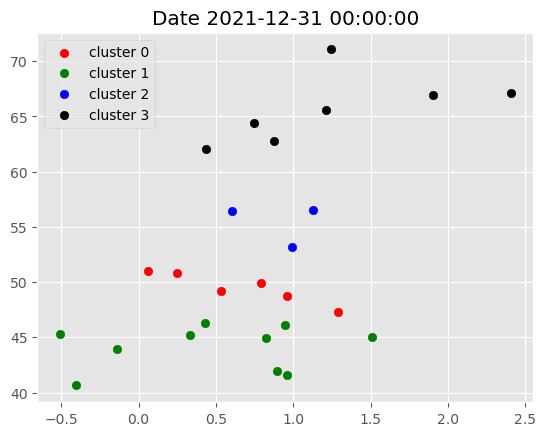

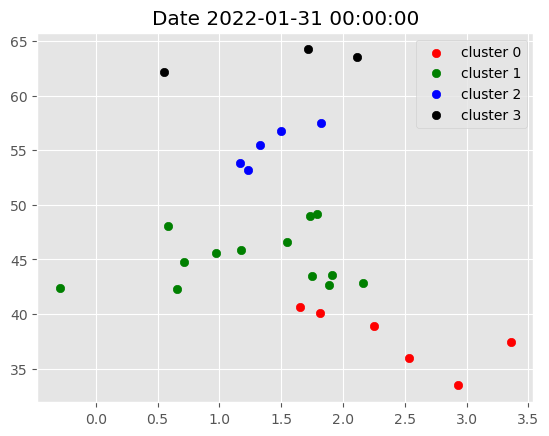

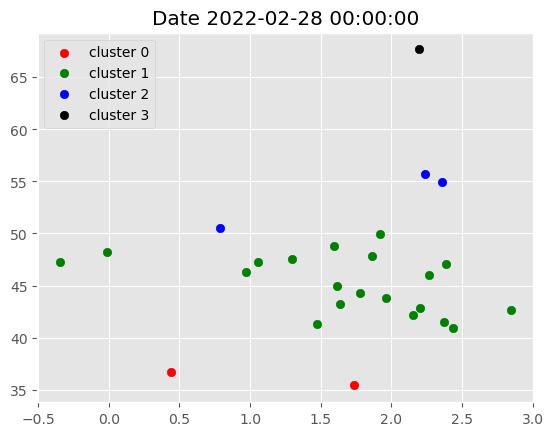

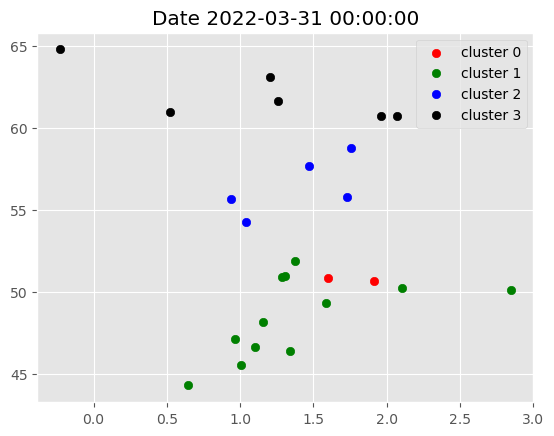

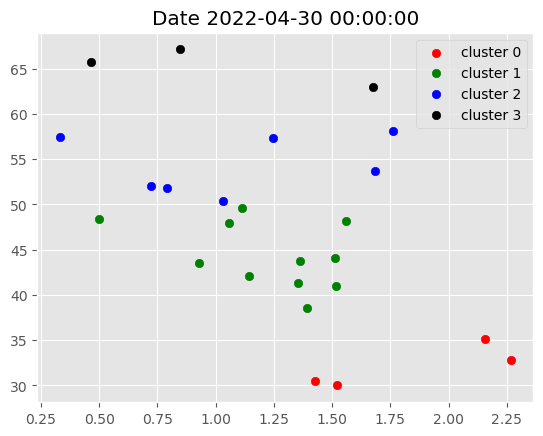

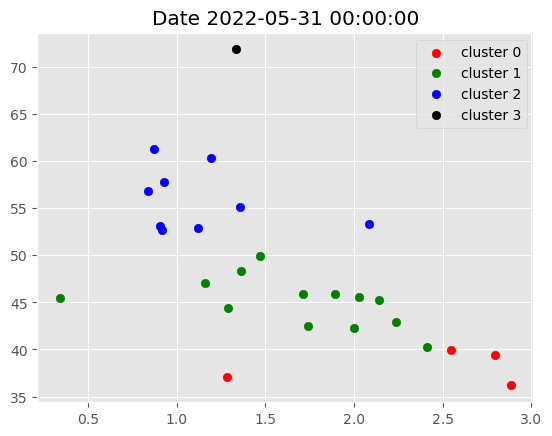

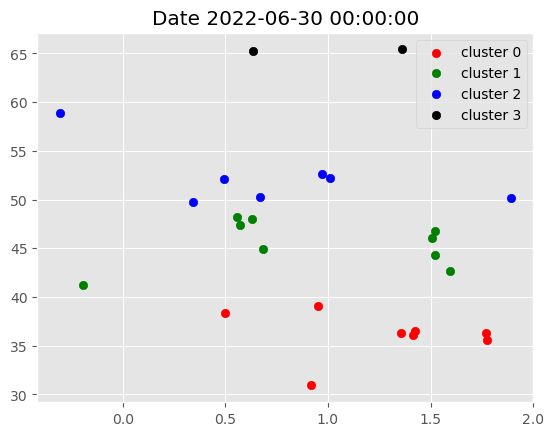

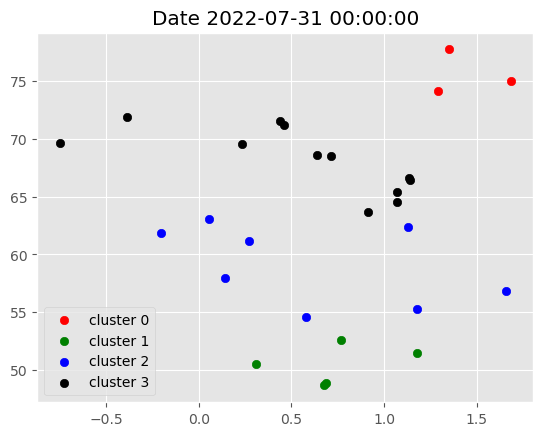

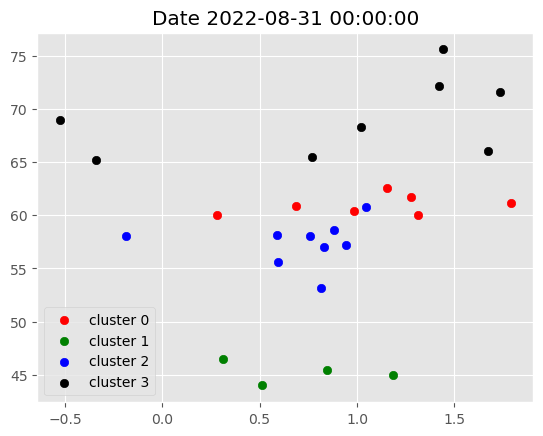

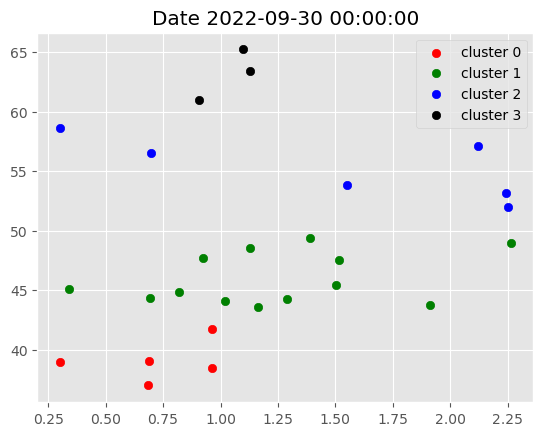

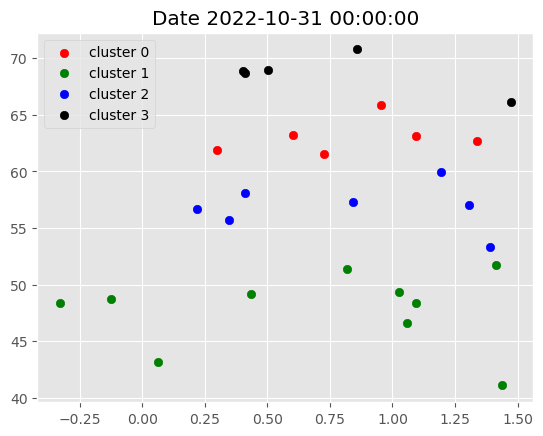

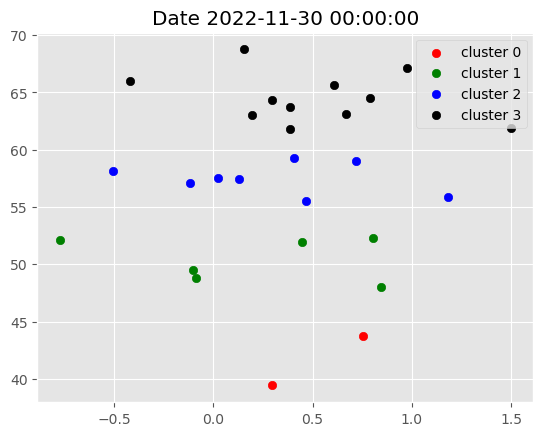

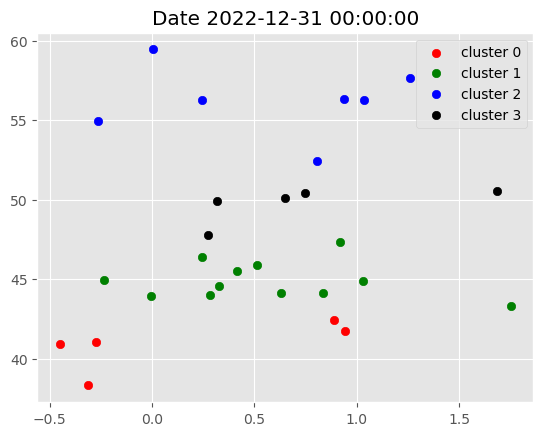

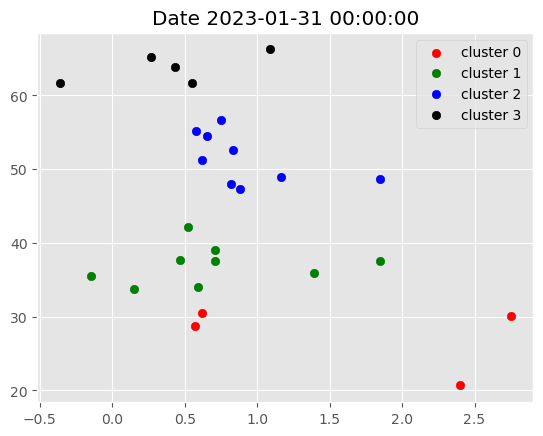

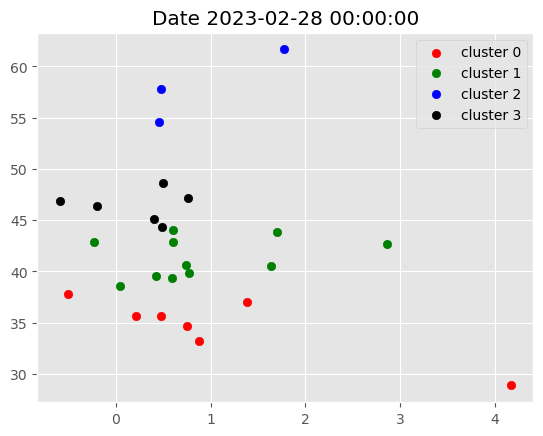

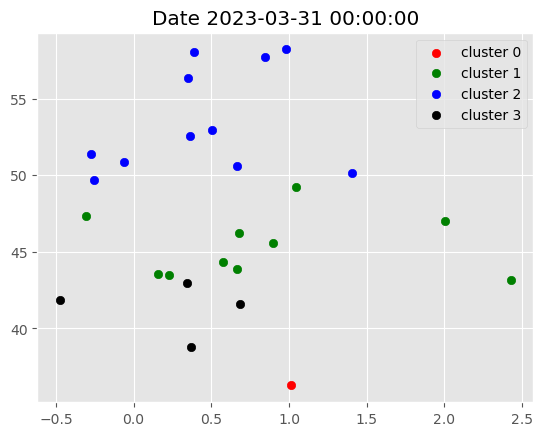

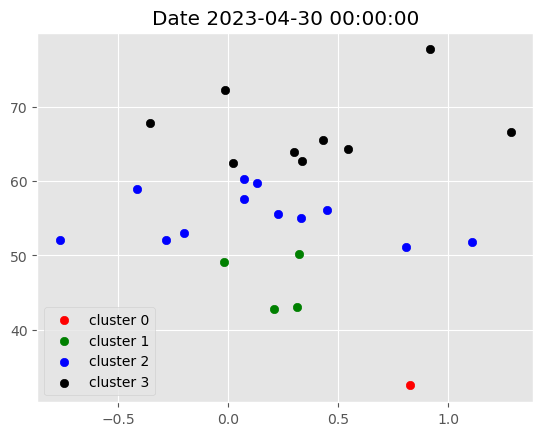

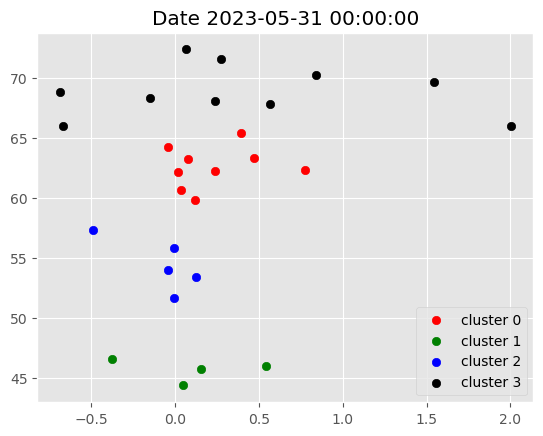

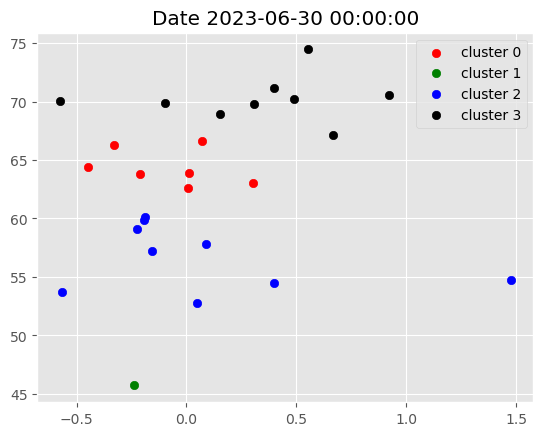

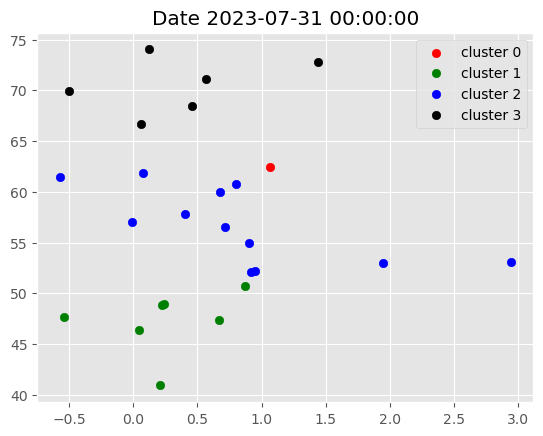

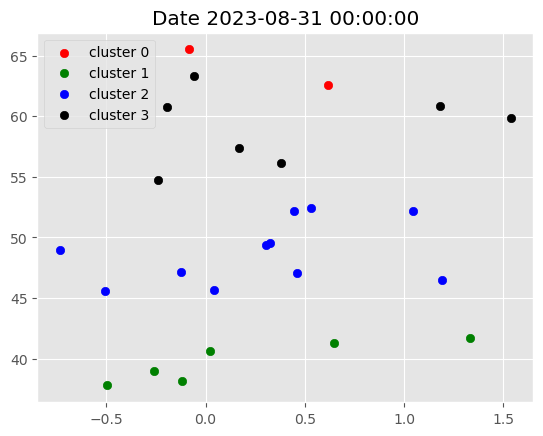

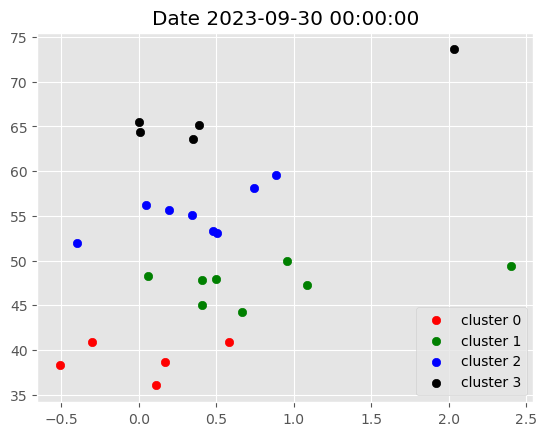

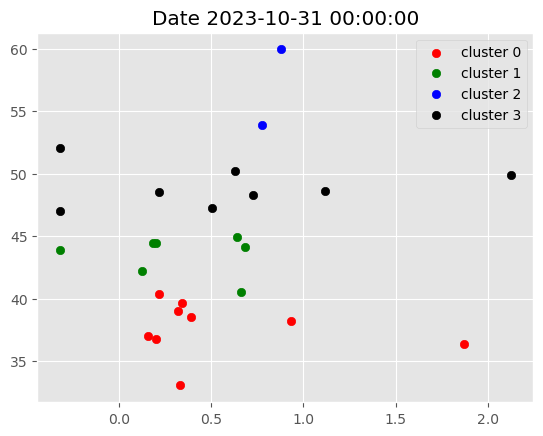

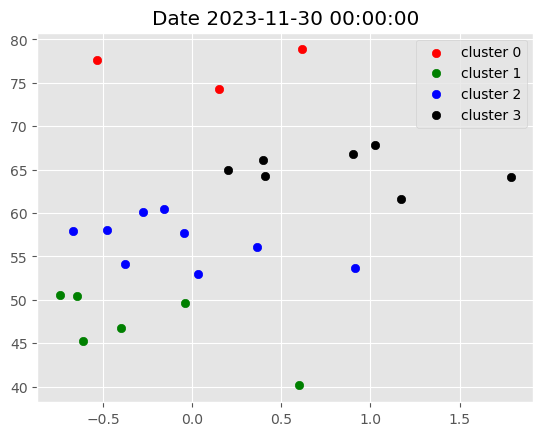

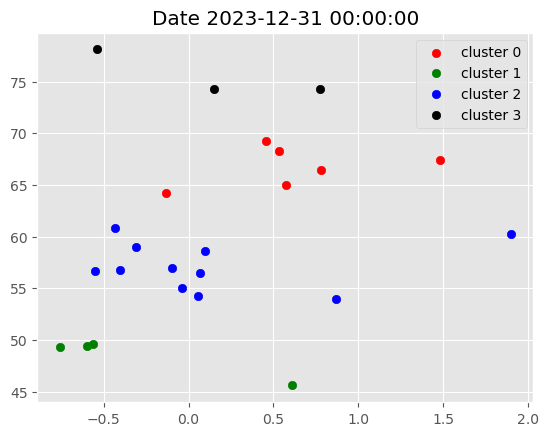

In [18]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [19]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

# 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [20]:
filtered_df = data[data['cluster']==1].copy()  # eveything lies here so use cluster value carefully

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {} # declare dictionary

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2017-02-01': ['AXISBANK.NS',
  'HCLTECH.NS',
  'INFY.NS',
  'RELIANCE.NS',
  'SUNPHARMA.NS',
  'TCS.NS'],
 '2017-03-01': ['TATAMOTORS.NS'],
 '2017-04-01': ['AXISBANK.NS',
  'BHARTIARTL.NS',
  'ICICIBANK.NS',
  'M&M.NS',
  'SUNPHARMA.NS',
  'TATAMOTORS.NS',
  'TCS.NS'],
 '2017-05-01': ['TATAMOTORS.NS', 'TATASTEEL.NS'],
 '2017-06-01': ['SUNPHARMA.NS'],
 '2017-07-01': ['EICHERMOT.NS',
  'HCLTECH.NS',
  'HINDALCO.NS',
  'INFY.NS',
  'KOTAKBANK.NS',
  'LT.NS',
  'M&M.NS',
  'SUNPHARMA.NS',
  'TCS.NS'],
 '2017-08-01': ['ITC.NS', 'SUNPHARMA.NS', 'TATAMOTORS.NS'],
 '2017-09-01': ['AXISBANK.NS',
  'INFY.NS',
  'ITC.NS',
  'KOTAKBANK.NS',
  'LT.NS',
  'M&M.NS',
  'SBIN.NS',
  'SUNPHARMA.NS'],
 '2017-10-01': ['ADANIPORTS.NS',
  'BHARTIARTL.NS',
  'BPCL.NS',
  'HEROMOTOCO.NS',
  'HINDUNILVR.NS',
  'INFY.NS',
  'LT.NS',
  'RELIANCE.NS',
  'TCS.NS'],
 '2017-11-01': ['BAJFINANCE.NS',
  'HCLTECH.NS',
  'HDFCBANK.NS',
  'INDUSINDBK.NS',
  'ITC.NS',
  'KOTAKBANK.NS'],
 '2017-12-01': ['ADANIPORTS.NS',


# Define portfolio optimization function
* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [21]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [22]:
stocks = data.index.get_level_values('ticker').unique().tolist()
new_df= yf.download(tickers= stocks,
                    start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12)
                    ,end=data.index.get_level_values('date').unique()[-1])
new_df

[*********************100%%**********************]  34 of 34 completed


Adj Close                                           \
            ADANIENT.NS ADANIPORTS.NS ASIANPAINT.NS  AXISBANK.NS   
Date                                                               
2016-02-01    39.376995    211.383316    840.552734   390.272919   
2016-02-02    38.056496    203.878296    835.911438   382.062744   
2016-02-03    38.003685    200.962326    818.104065   371.946747   
2016-02-04    38.162140    206.220596    842.399841   374.097015   
2016-02-05    38.928024    201.822784    851.777283   390.517212   
...                 ...           ...           ...          ...   
2023-12-22  2808.350098   1027.500000   3341.300049  1088.300049   
2023-12-26  2865.449951   1028.750000   3383.350098  1094.250000   
2023-12-27  2843.350098   1024.400024   3404.449951  1106.349976   
2023-12-28  2809.899902   1016.950012   3397.250000  1107.849976   
2023-12-29  2848.949951   1024.349976   3402.399902  1102.300049   

                                                                               \
           BAJAJFINSV.NS BAJFINANCE.NS BHARTIARTL.NS     BPCL.NS   DRREDDY.NS   
Date                                                                            
2016-02-01    185.553619    585.099854    256.739441  183.899368  2855.049072   
2016-02-02    181.028168    566.410889    261.586914  180.222000  2853.177490   
2016-02-03    187.047180    621.805359    259.509399  175.824036  2815.553223   
2016-02-04    187.271194    618.311279    263.361359  176.290314  2815.880859   
2016-02-05    190.039230    652.857910    265.914917  178.674774  2909.894531   
...                  ...           ...           ...         ...          ...   
2023-12-22   1672.050049   7295.299805    989.549988  446.649994  5627.700195   
2023-12-26   1645.300049   7162.299805    999.849976  451.600006  5632.149902   
2023-12-27   1669.449951   7232.799805   1021.200012  454.700012  5714.500000   
2023-12-28   1681.199951   7258.649902   1036.699951  465.799988  5858.549805   
2023-12-29   1685.800049   7327.750000   1032.199951  450.649994  5797.899902   

                         ...      Volume                                       \
           EICHERMOT.NS  ... RELIANCE.NS   SBIN.NS SUNPHARMA.NS TATAMOTORS.NS   
Date                     ...                                                    
2016-02-01  1620.984741  ...     4959404  22915269      3252050       6563774   
2016-02-02  1632.685913  ...     7385639  35957332      2676955       9179304   
2016-02-03  1590.637329  ...     7845739  24132003      2630864       6685445   
2016-02-04  1603.942993  ...     9101892  23811109      2287218       6086981   
2016-02-05  1720.224976  ...    10499202  22732245      2250196       9236577   
...                 ...  ...         ...       ...          ...           ...   
2023-12-22  4006.050049  ...     8270892  14998068      2058127      12062238   
2023-12-26  4040.399902  ...     3732832  10153089      1796483       7229143   
2023-12-27  4120.000000  ...     4602078  14417646      2005268      15052800   
2023-12-28  4091.899902  ...     6151318  16982092      2043365      14906199   
2023-12-29  4143.500000  ...     5432292  13221898      1840160      41170191   

                                                                            
           TATASTEEL.NS   TCS.NS TECHM.NS TITAN.NS ULTRACEMCO.NS  WIPRO.NS  
Date                                                                        
2016-02-01     46400199  1495274  2717866   659748        240216   4018593  
2016-02-02     88046083  1475588  5733789   757686        201113   3427580  
2016-02-03     81780438  1308692  2019903   723244        135537   1606738  
2016-02-04    122903030  1250046  1465102  1519516        103058   2804991  
2016-02-05    270834540  1402996  1196754  1549307        127269   2871047  
...                 ...      ...      ...      ...           ...       ...  
2023-12-22     37357334  2413058  2297352   777099        226940  23040407  
2023-12-26     259364

In [23]:
data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12)

Timestamp('2016-01-31 00:00:00')

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [24]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df
    

Max Sharpe Optimization failed for 2017-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-12-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-02-01, Continuing with Equal-Weights

Strategy Return
date                       
2017-02-01        -0.002475
2017-02-02         0.014746
2017-02-03         0.005353
2017-02-06         0.010000
2017-02-07        -0.004930
...                     ...
2023-12-22        -0.003875
2023-12-26         0.001107
2023-12-27         0.009951
2023-12-28         0.007482
2023-12-29        -0.005457

[1708 rows x 1 columns]

<Axes: xlabel='date'>

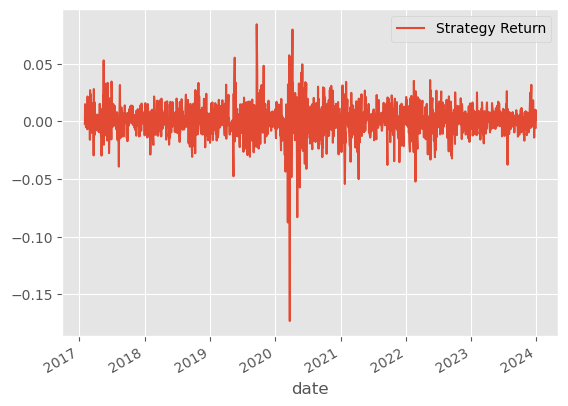

In [25]:
portfolio_df.plot()

In [26]:
pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T

BAJFINANCE.NS  INDUSINDBK.NS  KOTAKBANK.NS  SBIN.NS
0           0.25           0.25          0.25     0.25

In [27]:
nifty = yf.download(tickers='^NSEI',
                  start='2015-01-01',
                  end=dt.date.today())

nifty_ret = np.log(nifty[['Adj Close']]).diff().dropna().rename({'Adj Close':'nifty Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(nifty_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


Strategy Return  nifty Buy&Hold
2017-02-01        -0.002475        0.017954
2017-02-02         0.014746        0.002046
2017-02-03         0.005353        0.000767
2017-02-06         0.010000        0.006852
2017-02-07        -0.004930       -0.003728
...                     ...             ...
2023-12-22        -0.003875        0.004429
2023-12-26         0.001107        0.004298
2023-12-27         0.009951        0.009904
2023-12-28         0.007482        0.005708
2023-12-29        -0.005457       -0.002174

[1704 rows x 2 columns]

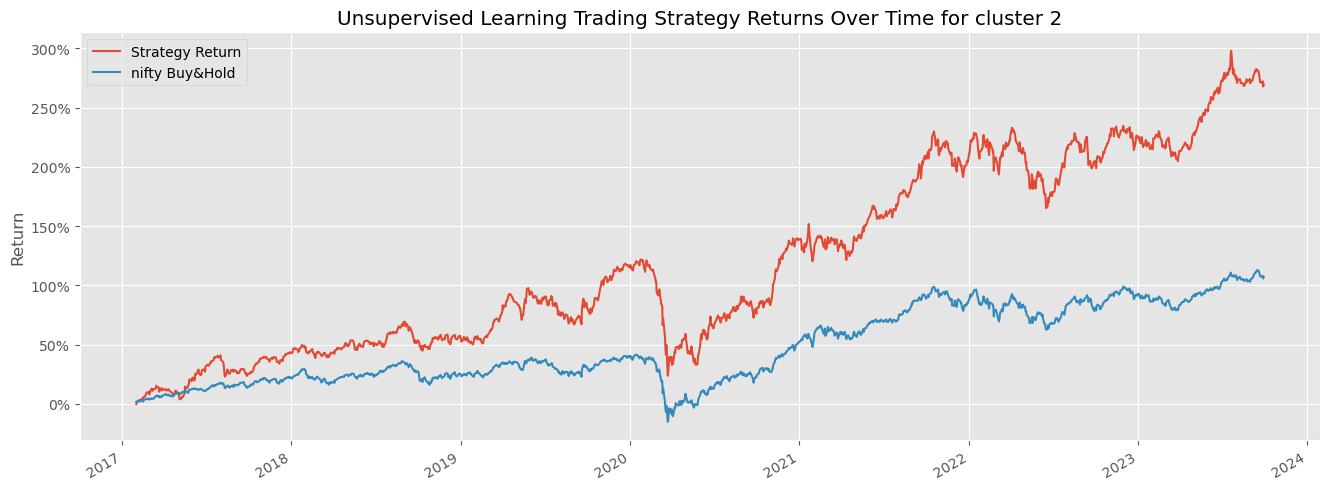

In [28]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time for cluster 2')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

In [29]:
import numpy as np

# Assuming 'portfolio_df' has the 'Strategy Return' and 'nifty Buy&Hold' columns
strategy_returns = portfolio_df['Strategy Return']
nifty_returns = portfolio_df['nifty Buy&Hold']

# Calculate Sharpe ratio for the strategy
strategy_sharpe_ratio = np.sqrt(252) * strategy_returns.mean() / strategy_returns.std()

# Calculate Sharpe ratio for NIFTY 50
nifty_sharpe_ratio = np.sqrt(252) * nifty_returns.mean() / nifty_returns.std()

# Print the Sharpe Ratios
print(f"Strategy Sharpe Ratio: {strategy_sharpe_ratio:.4f}")
print(f"NIFTY 50 Sharpe Ratio: {nifty_sharpe_ratio:.4f}")


Strategy Sharpe Ratio: 1.0271
NIFTY 50 Sharpe Ratio: 0.7916
